In [1]:
import numpy as np
import crispr_assembler as ca
import matplotlib.pyplot as plt
import editdistance as ed
import os
import pickle

import tqdm


%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
path = '/home/anton/BigMac/skoltech/CRISPR_research/article/newdata/'
folders = sorted(os.listdir(path))

In [5]:
answer_all = ca.read_arrays_with_tags("../../article/data/answers/all_refresh", 0)

In [6]:
keys_1 = ['first_8', 'second_8']

keys_2 = ['first_8', 'second_8', 'first_50', 'second_50']

keys_10 = ['first_2', 'first_3', 'first_5', 'first_7',
        'first_8', 'first_21', 'first_27', 'first_65', 
        'first_9', 'first_12', 
        'second_2',  'second_5',  'second_21', 'second_65',
        'second_3', 'second_7', 'second_8', 'second_27',
        'second_9', 'second_12']

In [7]:
answer_all.keys()

dict_keys(['first_1', 'first_11', 'first_2', 'first_24', 'first_61', 'first_62', 'first_68', 'first_3', 'first_5', 'first_50', 'first_7', 'first_8', 'first_14', 'first_15', 'first_19', 'first_20', 'first_22', 'first_31', 'first_21', 'first_23', 'first_27', 'first_65', 'first_70', 'first_9', 'first_12', 'first_66', 'first_67', 'second_1', 'second_2', 'second_61', 'second_62', 'second_68', 'second_5', 'second_50', 'second_21', 'second_65', 'second_70', 'second_3', 'second_7', 'second_8', 'second_11', 'second_14', 'second_15', 'second_19', 'second_20', 'second_22', 'second_23', 'second_24', 'second_27', 'second_31', 'second_9', 'second_12', 'second_66', 'second_67'])

In [8]:
def generate_answer(answer_all, keys):
    answ = {}

    for key in keys:
        answ[key] = answer_all[key]
    return answ

In [9]:
answ_1, answ_2, answ_10 = [generate_answer(answer_all, x) for x in [keys_1, keys_2, keys_10]]

In [10]:
answers = [answ_1, answ_2, answ_2, answ_10, answ_10]

# Calc answ

In [11]:
folders[:5]

['r1', 'r2', 'r3', 'r4', 'r5']

In [12]:
#res = [restore("../../article/newdata/r5/out/pairs/Anton_R5_S51_R1_001.fastq.gz_pairs.txt")]
res = []

for folder in folders[:5]:
    files = os.listdir(path + folder + "/out/pairs")
    res.append(ca.restore(path + folder + "/out/pairs/" + files[0], 5))

100%|██████████| 739/739 [00:00<00:00, 2495.50it/s]


In [13]:
answers_ids = []

for a, r in zip(answers, res):
    answers_ids.append(ca.multiple_arrays_to_ids(a, r.spacer_to_cluster_index))

100%|██████████| 20/20 [00:00<00:00, 54.76it/s]


In [14]:
for a, a_sp in zip(answers_ids[:], answers[:]):
    seen = []
    good_distances = 0
    
    for k in a[0].keys():
        for dist, spacer in zip (a[1][k], a_sp[k]):
            
            if ca.find_closest(seen, spacer)[0] > 6:
                seen.append(spacer)
                if dist < 5:
                    good_distances += 1
            else:
                #print("seen", spacer, k)
                pass
    
                
    print(good_distances, len(seen), good_distances / len(seen))
    #ca.unwrap_nested([x for x in a[1].values()])
    #print([x < 5 for x in ca.unwrap_nested([x for x in a[1].values()])])
    #print(sum([x < 5 for x in ca.unwrap_nested([x for x in a[1].values()])]), len(ec.cluster_to_index))
    #[x ca.unwrap_nested([x for x in a[1].values()]) 

18 18 1.0
19 20 0.95
20 20 1.0
126 132 0.9545454545454546
122 132 0.9242424242424242


In [15]:
answer_ids_fixed = []

for a in answers_ids[:]:
    new_dict = {}
    
    m = max(ca.unwrap_nested([x for x in a[0].values()]))
    print(m)
    for k in a[0].keys():
        mask = np.array([x > 5 for x in a[1][k]])
        new_array = np.array(a[0][k])
        new_array[mask] = m + 1
        
        new_dict[k] = new_array
    
    answer_ids_fixed.append((new_dict, a[1]))

38
18
20
131
185


In [16]:
grs = [x.graph_from_pairs()[0] for x in tqdm.tqdm(res)]

100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


In [17]:
[x.shape for x in grs]

[(40, 40), (34, 34), (23, 23), (136, 136), (189, 189)]

In [18]:
cuts = [17, 18, 18, 200, 200]

In [19]:
grs = [x[:c, :c] for x, c in zip(grs, cuts)]

In [20]:
[x.shape for x in grs]

[(17, 17), (18, 18), (18, 18), (136, 136), (189, 189)]

In [21]:
gb = pickle.load(open("./linear_svc_rep_to_rep", "rb"))
gb = pickle.load(open("./lr_rep_to_rep", "rb"))

In [22]:
ec = ca.EmbeddingsCalculator()

In [23]:
embs = []
for gr in tqdm.tqdm(grs):
    ec = ca.EmbeddingsCalculator()
    embs.append(ec.fit_predict(gr))

100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


In [24]:
pred_grs = [gb.predict(emb).reshape(gr.shape) for emb, gr in zip(embs, grs)]

In [25]:
answer_grs = [ca.graph_from_arrays([list(x) for x in a[0].values()])[0] for a in answer_ids_fixed]

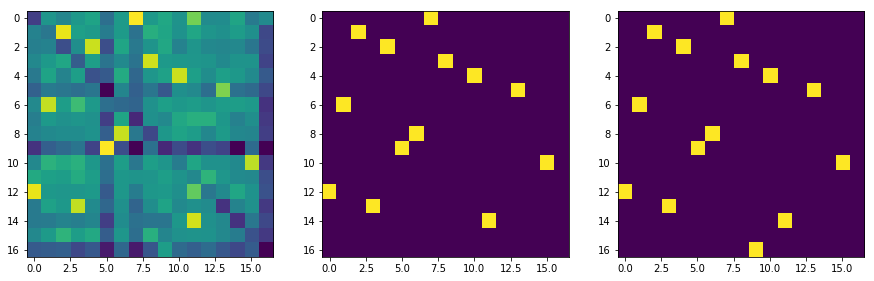

In [26]:
ind = 0
ca.plot_grs(grs[ind][:100, :100], pred_grs[ind][:100, :100], answer_grs[ind][:100, :100],  log=1, s =15)

In [29]:
idx = 3
arrs = [x for x in ca.restore_arrays_all(pred_grs[idx])[0] if len(x) > 1]
arrs_gr = [x for x in  ca.restore_arrays_greedy(grs[idx], 25)[0] if len(x) > 1]


In [30]:
def to_dict(arrs, prefix):
    return dict(zip([prefix + str(x)]))

In [27]:
from importlib import reload
ca = reload(ca)

In [28]:
import crispr_assembler as ca

In [29]:
ca = reload(ca)

In [30]:
test_arrays = [[2,4,5]]#, [3,4,6,5]]#, [0,1,2,3], [0,2,3,4], [3,4,5,6,7,8], [1,2,-1]]
alignments = ca.water_alignments([1,2,3,4,5], test_arrays)
aligned_seqs = ca.process_multiple_alignments(alignments)
s, t =  ca.preprint_multiple_alignments(aligned_seqs)

In [31]:
alignments

array([[list([1, 2, 3, 4, 5]), list([2, 4, 5]), list([1, 2, 3, 4, 5]),
        list(['-', 2, '-', 4, 5]), 1, 5, 0, 3, 0.8, 1.0, 20.0]],
      dtype=object)

In [32]:
print(ca.preprint_seq(s))
for t_ in t:
    print(ca.preprint_seq(t_))

 1  , 2  , 3  , 4  , 5  ,
 -  , 2  , -  , 4  , 5  ,


In [33]:
test_arrays = [[2,4,5], [3,4,6,5]]
alignments = ca.water_alignments([1,2, 3,4,5], test_arrays)
aligned_seqs = ca.process_multiple_alignments(alignments)
s, t =  ca.preprint_multiple_alignments(aligned_seqs)

In [34]:
def get_links(arrs):
    max_len = max([len(x) for x in arrs])
    arrs_np = np.ones((len(arrs), max_len)).astype(int) * -1
    
    for i, a in enumerate(arrs):
        arrs_np[i][:len(a)] = np.array(a)
    
    
    #return arrs_np

    links = [[] for x in range(len(arrs))]
    for i, a in enumerate(arrs):
        for j, x in enumerate(a):
            mask = np.where(arrs_np == x)
            #print(i, j, mask)
            local_links = []
            for i1, j1 in zip(mask[0], mask[1]):
                if i1 != i or j1 != j:
                    local_links.append((i1, j1))
            links[i].append(local_links)
            
    return links, arrs_np
    

In [35]:
def align(arrs, arrs_np, links, v = 0, max_iter=50):
    new_arrs = [[] for x in range(len(arrs))]
    pointers = [[i, 0] for i in range(len(arrs))]
    lens = [len(a) for a in arrs]

    def should_continue(pointers):
        if all([pointers[i][1] == lens[i] - 1 for i in range(len(arrs))]):
            return False
        else:
            return True

    def pointer_movable(p, mask):
        return mask[p[0]]
    
    movable_pointers_mask = np.array([pointers[i][1] < len(arrs[i]) for i in range(len(arrs))])

    it = 0
    while any(movable_pointers_mask) and it < max_iter:
        if v:print("-------------------------")
        curr_links = []
        movable_pointers_mask = np.array([pointers[i][1] < len(arrs[i]) for i in range(len(arrs))])
        
        for p in pointers:
            if pointer_movable(p, movable_pointers_mask):
                curr_links.append(links[p[0]][p[1]])
            else:
                curr_links.append([])

        links_mask = np.array([len(l) == 0 for l in curr_links])

        if v:
            print('p', pointers)
            print('cl', curr_links)
            print('lm', links_mask)
            print('mpm', movable_pointers_mask)

        if any(np.logical_and(movable_pointers_mask, links_mask)):
            p_to_move = np.where(np.logical_and(movable_pointers_mask, links_mask))[0][0]
            p = pointers[p_to_move]

            for i in range(len(new_arrs)):
                if i == p[0]:
                    new_arrs[i].append(arrs[p[0]][p[1]])
                else:
                    new_arrs[i].append('-')

            pointers[p_to_move][1] += 1

        else:
            links_clusters = set()
            for l, p in zip(curr_links, pointers):
                l_copy = [x for x in l]
                l_copy.append(p)

                l_copy = tuple(frozenset([tuple(x) for x in l_copy]))
                if len(l_copy) > 1:
                    links_clusters.add(l_copy)

            pointers_set = set([tuple(x) for x in pointers])

            if v : 
                print('ps', pointers_set)
                print('lc', links_clusters)
        
            for s in links_clusters:
                good_set = True
                if v:print('s', s)
                for el in s:
                    #if v:print('el', el)
                    if not el in pointers_set:
                        good_set = False

                if good_set:
                    if v:print('s', s)
                    completed_arrs = []

                    for el in s:
                        if  movable_pointers_mask[el[0]]:
                            new_arrs[el[0]].append(arrs[el[0]][el[1]])
                        pointers[el[0]][1] += 1
                        completed_arrs.append(el[0])

                    for i in range(len(arrs)):
                        if not i in completed_arrs:
                            new_arrs[i].append('-')
                    break
        movable_pointers_mask = np.array([pointers[i][1] < len(arrs[i]) for i in range(len(arrs))])
        if v:
            for i in range(len(arrs)):
                print(pointers[i][1], len(arrs[i]), arrs[i])
        if v:print('p', pointers)
        if v:print('mpm', movable_pointers_mask)         
        if v:print('na', new_arrs)
        it += 1
    return new_arrs

In [36]:
tmp

NameError: name 'tmp' is not defined

In [37]:
tmp1 = [[186, 160, 135, 134, 140, 148, 133, 149, 158, 139, 130, 136, 168],
 [133, 149, 158, 139, 130, 136],
 [160, 135, 152, 134, 140]]

In [371]:
links, arrs_np = get_links(tmp1)
new_arrs = align(tmp1, arrs_np, links, v= 1)

-------------------------
p [[0, 0], [1, 0], [2, 0]]
cl [[], [(0, 6)], [(0, 1)]]
lm [ True False False]
mpm [ True  True  True]
1 13 [186, 160, 135, 134, 140, 148, 133, 149, 158, 139, 130, 136, 168]
0 6 [133, 149, 158, 139, 130, 136]
0 5 [160, 135, 152, 134, 140]
p [[0, 1], [1, 0], [2, 0]]
mpm [ True  True  True]
na [[186], ['-'], ['-']]
-------------------------
p [[0, 1], [1, 0], [2, 0]]
cl [[(2, 0)], [(0, 6)], [(0, 1)]]
lm [False False False]
mpm [ True  True  True]
ps {(0, 1), (2, 0), (1, 0)}
lc {((0, 1), (2, 0)), ((0, 6), (1, 0))}
s ((0, 1), (2, 0))
s ((0, 1), (2, 0))
2 13 [186, 160, 135, 134, 140, 148, 133, 149, 158, 139, 130, 136, 168]
0 6 [133, 149, 158, 139, 130, 136]
1 5 [160, 135, 152, 134, 140]
p [[0, 2], [1, 0], [2, 1]]
mpm [ True  True  True]
na [[186, 160], ['-', '-'], ['-', 160]]
-------------------------
p [[0, 2], [1, 0], [2, 1]]
cl [[(2, 1)], [(0, 6)], [(0, 2)]]
lm [False False False]
mpm [ True  True  True]
ps {(1, 0), (0, 2), (2, 1)}
lc {((0, 2), (2, 1)), ((0, 6), 

In [372]:
new_arrs

[[186, 160, 135, '-', 134, 140, 148, 133, 149, 158, 139, 130, 136, 168],
 ['-', '-', '-', '-', '-', '-', '-', 133, 149, 158, 139, 130, 136, '-'],
 ['-', 160, 135, 152, 134, 140, '-', '-', '-', '-', '-', '-', '-', '-']]

In [38]:
def create_combined_array(alignments):
    combined = []
    i, j = 0, 0
    
    while j < len(alignments[0]): 
        if alignments[i][j] != '-':
            combined.append(alignments[i][j])
            j += 1
        else:
            i += 1
            i = i % len(alignments)
    
    return combined

In [39]:
def fix_arr(a):
    seen = set()
    fixed = []
    for el in a:
        if el in seen:
            fixed.append(-1)
        else:
            fixed.append(el)
            seen.add(el)
    return fixed

In [41]:
arrs = [[1,2,3,4,5], [2,4,5], [7,3,4,6,5,8]]

In [42]:
links, arrs_np = get_links(arrs)
new_arrs = align(arrs, arrs_np, links)

In [43]:
arrs = [[123, 15, 1, 30],
 [1, 30, 89, 81, 83, 103, 110],
 [15, 1, 78, 99],
 [123, 15, 1, 30, 89, 81, 83, 103, 110],
 [123, 15, 1, 78, 99]]

In [44]:
links, arrs_np = get_links(arrs)
new_arrs = align(arrs, arrs_np, links, v= 0)

In [45]:
combined = create_combined_array(new_arrs)

In [46]:
print(ca.preprint_seq(combined))
print()
for x in new_arrs:
    print(ca.preprint_seq(x))

 123, 15 , 1  , 30 , 78 , 99 , 89 , 81 , 83 , 103, 110,

 123, 15 , 1  , 30 , -  , -  , -  , -  , -  , -  , -  ,
 -  , -  , 1  , 30 , -  , -  , 89 , 81 , 83 , 103, 110,
 -  , 15 , 1  , -  , 78 , 99 , -  , -  , -  , -  , -  ,
 123, 15 , 1  , 30 , -  , -  , 89 , 81 , 83 , 103, 110,
 123, 15 , 1  , -  , 78 , 99 , -  , -  , -  , -  , -  ,


# plot/

In [40]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [41]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(151)

In [42]:
def draw_array(ax, array, cmap, x0, y0, step = 0.04):
    rectangles = []
    for i, a in enumerate(array):
        if a == '-':
        #if '-' in a:
            color = 'none'
        else:
            color = 'b'#cmap(a*16 % cmap.N)
        rectangles.append(Rectangle((x0 + i * step*2, y0), step*2, step,linewidth=1,
                                    edgecolor='black',
                                    facecolor=color,
                                    alpha = 0.3))
        plt.text(x0 + i * step*2, y0, a)

    for r in rectangles:
        ax.add_patch(r)
    return rectangles #rectangles

In [43]:
def draw_array_triangles(ax, array, cmap, x0, y0, mask = None, step = 0.04, color=None):
    rectangles = []
    for i, a in enumerate(array):
        if color is None:
            if not mask is None:
                if mask[i] == 0 :
                    color = 'none'
                elif mask[i] == 1:
                    color = 'g'
                elif mask[i] == 2:
                    color = 'y'
            else:
                if a == '-':
                    color = 'none'
                else:
                    color = cmap(3)
        
        #import ipdb; ipdb.set_trace()
        if a != "-":
            rectangles.append(plt.Polygon([[x0 + i * step*2, y0],
                                           [x0 + (i + 1) * step*2, y0],
                                           [x0 + i * step*2 + step,  y0 + step *1.1]],
                                      #edgecolor='black',
                                      facecolor=color,
                                      alpha = 0.5))
        else:
            rectangles.append(Rectangle((x0 + i * step*2, y0), step*2, step,linewidth=1,
                                    edgecolor='black',
                                    facecolor='none',
                                    alpha = 0.2))
            
        plt.text(x0 + i * step*2, y0, a)

    for r in rectangles:
        ax.add_patch(r)
    return rectangles #rectangles

In [44]:
def draw_allignment(ax, seq, targets, base_key, keys, cmap, x0, y0, colors, step=0.04):
    rectangles = draw_array(ax, seq, cmap, x0, y0)
    plt.text(x0 - 10 * step, y0 , base_key)
    
    #plt.show()
    i = 0 
    for i, t in enumerate(targets[:]):
        mask = []
        for j in range(len(seq)):
            if seq[j] == t[j] and seq[j] == '-':
                mask.append(0)
            elif seq[j] == t[j]:
                mask.append(1)
            else:
                mask.append(2)


        rectangles = draw_array_triangles(ax, t, cmap, x0, y0 - (i+1) * step, mask, color = colors[i])
        plt.text(x0 - 10 * step, y0 - (i+1) * step, keys[i])
#         else:
#             rectangles = draw_array(ax, t,cmap, y0 - (i+1) * step)
    return y0 - (i+2) * step

In [45]:
arrs_gr, w = ca.restore_arrays_greedy(grs[3], 25)

In [46]:
idxes = [2, 3, 5, 7, 8, 9, 12, 21, 27, 65]
keys = ca.unwrap_nested([['first_' +  str(x), 'second_' + str(x)] for x in idxes])

In [47]:
ca = reload(ca)

#### aligned_seqs[0]

In [329]:
ca = reload(ca)

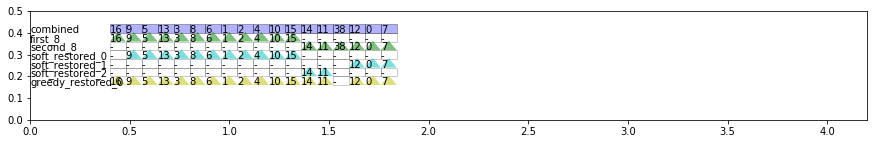

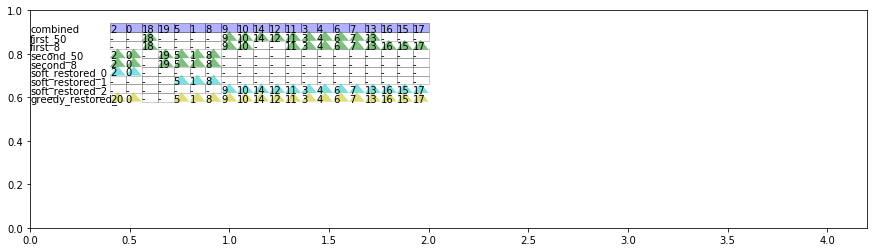

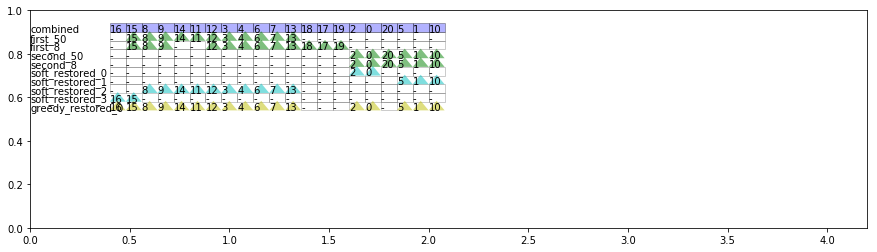

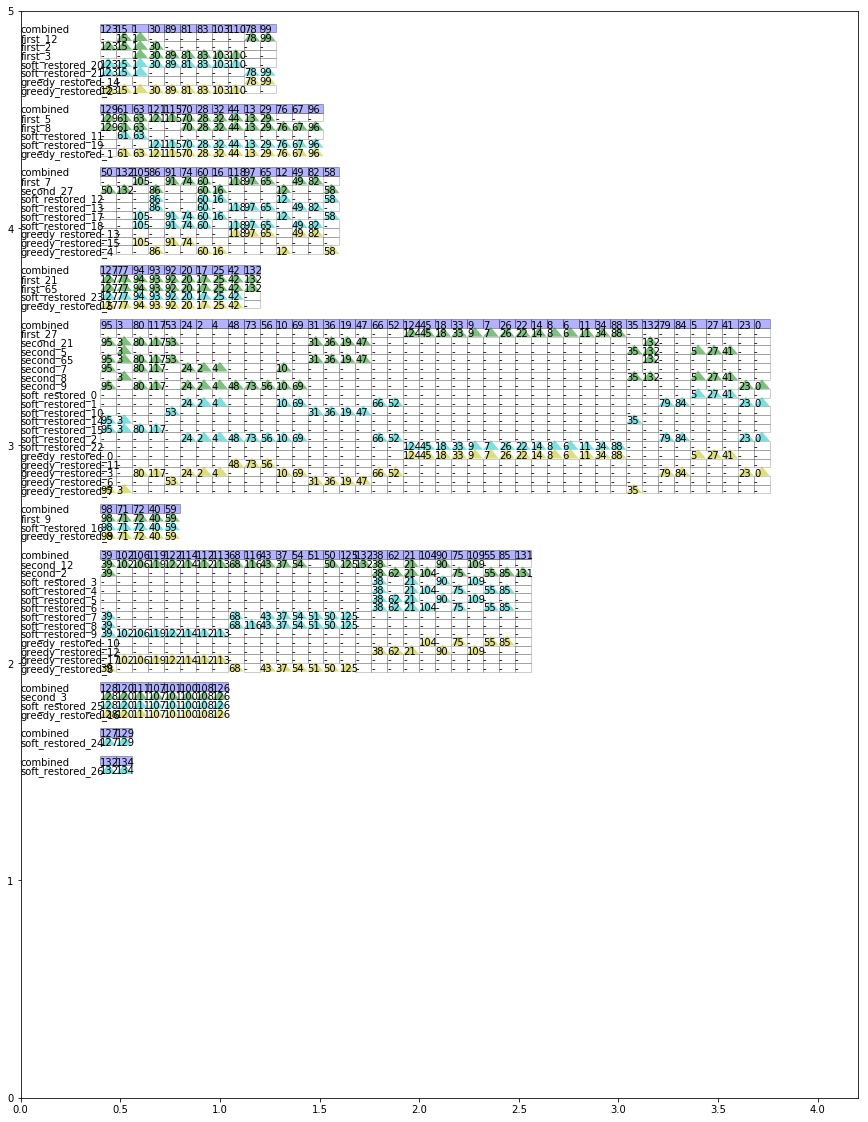

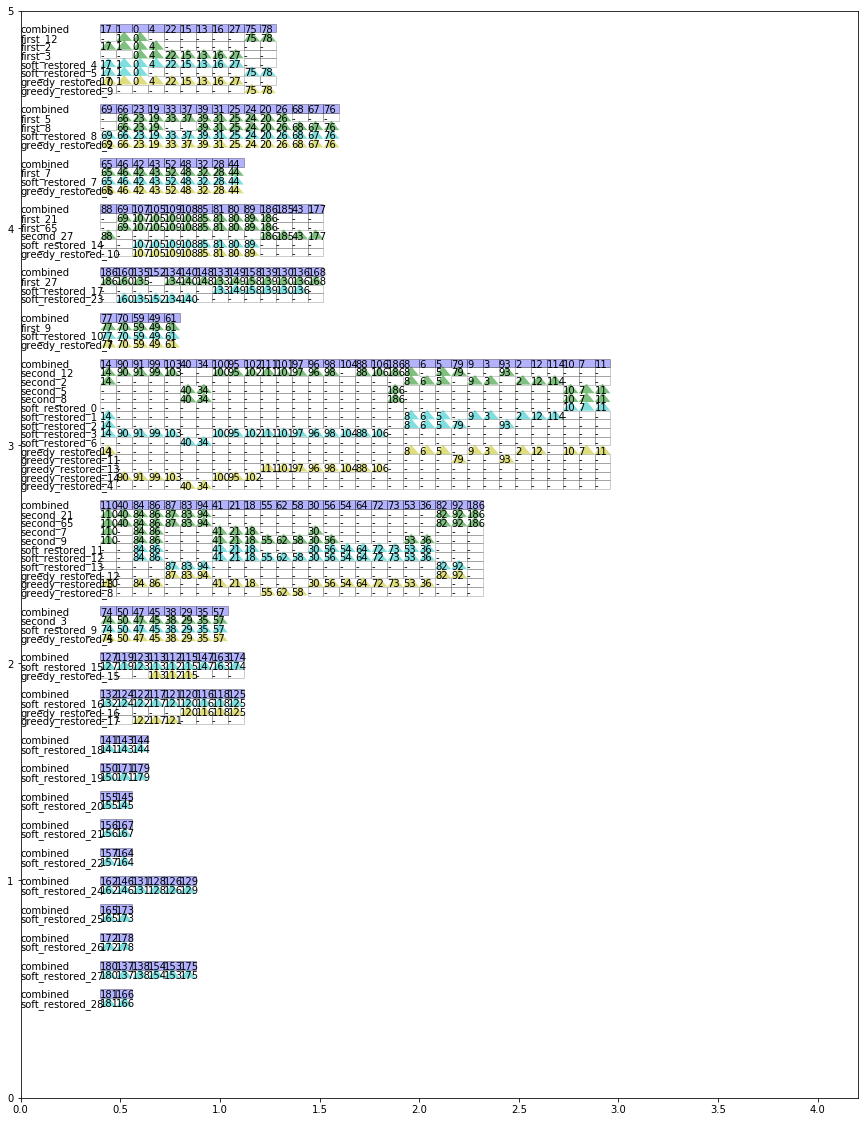

In [62]:
for idx in range(5):
    arrs = [x for x in ca.restore_arrays_all(pred_grs[idx])[0] if len(x) > 1]
    arrs_gr = [x for x in  ca.restore_arrays_greedy(grs[idx], 25)[0] if len(x) > 1]

    arrs_keys = dict(zip([tuple(x) for x in arrs],np.arange(len(arrs))))
    arrs_gr_keys = dict(zip([tuple(x) for x in arrs_gr],np.arange(len(arrs_gr))))

    candidates = dict()
    for key, val in answer_ids_fixed[idx][0].items():
        candidates[key] = list(val) 
    for i, a in enumerate(arrs):
        candidates['soft_restored_' + str(i)] = a
    for i, a in enumerate(arrs_gr):
        candidates['greedy_restored_' + str(i)] = a

    fig, ax = plt.subplots(1, figsize = (15,1 * len (answer_ids_fixed[idx][0])))
    ax.set_xlim(0,4.2)
    ax.set_ylim(0,0.25 * len(answer_ids_fixed[idx][0]))
    y0 = len(answer_ids_fixed[idx][0]) * 0.25 - 0.1


    seen_keys = set()

    for k,v in list(candidates.items())[:]:
        if not k in seen_keys:
            aligned_arrs = [v]
            aligned_keys = [k]
            curr_keys_pool = set()
            curr_keys_pool.add(k)
            search_candidates = [v]
            search = True

            #import ipdb; ipdb.set_trace() 
            max_iter = 0
            while search and max_iter < 10:
                search = False
                new_search_candidates = []
                for c in search_candidates:
                    alignments = ca.water_alignments_dict(c, candidates)
                    keys = sorted(list(alignments.keys()))

                    for key in keys:
                        if not key in curr_keys_pool:
                            curr_keys_pool.add(key)
                            aligned_arrs.append(alignments[key][1])
                            aligned_keys.append(key)
                            search = True
                            new_search_candidates.append(candidates[key])   

                search_candidates = new_search_candidates
                max_iter += 1    

            for el in curr_keys_pool:
                seen_keys.add(el)

            aligned_arrs_fixed = [fix_arr(el) for el in aligned_arrs]

            links, arrs_np = get_links(aligned_arrs_fixed)
            new_arrs = align(aligned_arrs_fixed, arrs_np, links)

    #         if k == 'zrestored_15':
    #             print(aligned_arrs)
    #             print(new_arrs)
    #             tmp = aligned_arrs
            combined = create_combined_array(new_arrs)


            order,colors = sort_names(aligned_keys)
            new_arrs = np.array(new_arrs)
            aligned_keys = np.array(aligned_keys)

    #         for x,key in zip(new_arrs[order], aligned_keys[order]):
    #             print(key+ ' '*(20 - len(key)) , ca.preprint_seq(x))

    #         print(curr_keys_pool)
    #         print("-----------------")


#             colors = np.array(['g'] * len(aligned_keys))
#             colors[[x[0]  == 'z' for x in aligned_keys[order]]] = 'y'

            y0 = draw_allignment(ax, combined, list(new_arrs[order]), 'combined',  aligned_keys[order], cmap, 0.4, y0, colors)
            y0 -= 0.05

    fig.savefig("../../article/pics/cluster_alignments/" + str(idx) + '.png')
    # #plt.show()

    #dict_keys(['second_21', 'second_65', 'second_7', 'second_9', 'restored_1', 'restored_2', 'restored_15'])

In [60]:
def sort_names(names, keys_order = ['first', 'second', 'soft', 'greedy']): 
    order = np.argsort(names)
    
    names_presorted = np.array(names)[order]
    
    new_order = []
    key_to_color = dict(zip(keys_order, ['g','g','c','y']))
    colors = []
    
    for key in keys_order:
        for name, idx in zip(names_presorted, order):
            if name.split("_")[0] == key:
                new_order.append(idx)
                colors.append(key_to_color[key])
                
                
    return np.array(new_order), colors
    

In [53]:
aligned_keys[sort_names(aligned_keys)]

array(['first_8', 'second_8', 'soft_restored_0', 'soft_restored_1',
       'soft_restored_2', 'greedy_restored_0'], dtype='<U17')

In [51]:
sort_names(aligned_keys)

[0, 3, 2, 4, 5, 1]

In [378]:
candidates['zrestored_15']

[127, 119, 123, 113, 112, 115, 147, 163, 174]

In [360]:
candidates['zrestored_17']

[133, 149, 158, 139, 130, 136]

In [328]:
[x[0] for x in  aligned_keys[order]]

['z']

In [319]:
for k, v in candidates.items():
    if 52 in v:
        print(k, v)

zrestored_1 [24, 2, 4, 10, 69, 66, 52, 79, 84, 23, 0, 57, 64, 46, 87]
zrestored_2 [24, 2, 4, 48, 73, 56, 10, 69, 66, 52, 79, 84, 23, 0, 57, 64, 46, 87]


In [228]:
major_key = 'first_9'
seen_keys = set()
max_iter = 0
for k,v in zip([major_key], [candidates[major_key]]):#list(candidates.items())[:]:
    if not k in seen_keys:
        aligned_arrs = [v]
        aligned_keys = [k]
        curr_keys_pool = set()
        curr_keys_pool.add(k)
        search_candidates = [v]
        search = True
        
        #import ipdb; ipdb.set_trace() 
        
        while search and max_iter < 10:
            search = False
            new_search_candidates = []
            for c in search_candidates:
                alignments = ca.water_alignments_dict(c, candidates)
                keys = sorted(list(alignments.keys()))
                
                for key in keys:
                    if not key in curr_keys_pool:
                        curr_keys_pool.add(key)
                        aligned_arrs.append(alignments[key][1])
                        aligned_keys.append(key)
                        search = True
                        new_search_candidates.append(candidates[key])   
                        
            search_candidates = new_search_candidates
            max_iter += 1    
            
        for el in curr_keys_pool:
            seen_keys.add(el)
                
            
            
        
        links, arrs_np = get_links(aligned_arrs)
        new_arrs = align(aligned_arrs, arrs_np, links)
        combined = create_combined_array(new_arrs)
        
        #y_tmp = draw_allignment(ax, combined, new_arrs, ' ', keys, cmap, 0.4, y0)
        
#         print(' ', ca.preprint_seq(combined))
#         print()
        for x,key in zip(new_arrs, aligned_keys):
            print(key+ ' '*(20 - len(key)) , ca.preprint_seq(x))
            
        print(curr_keys_pool)
        print("-----------------")


#     y0 = y_tmp
#     y0 -= 0.05
# #plt.show()

#dict_keys(['second_21', 'second_65', 'second_7', 'second_9', 'restored_1', 'restored_2', 'restored_15'])

first_9               98 , 71 , 72 , 40 , 59 ,
restored_16           98 , 71 , 72 , 40 , 59 ,
{'first_9', 'restored_16'}
-----------------


In [219]:
# fig, ax = plt.subplots(1, figsize = (15,1 * len (answer_ids_fixed[idx][0])))
# ax.set_xlim(0,4.2)
# ax.set_ylim(0,0.2 * len(answer_ids_fixed[idx][0]))
# y0 = len(answer_ids_fixed[idx][0]) * 0.2 - 0.1


seen_keys = set()
max_iter = 0
for k,v in  #list(candidates.items())[:]:
    if not k in seen_keys:
        aligned_arrs = [v]
        curr_keys_pool = set()
        curr_keys_pool.add(k)
        search_candidates = [v]
        search = True
        
        #import ipdb; ipdb.set_trace() 
        
        while search and max_iter < 10:
            search = False
            new_search_candidates = []
            for c in search_candidates:
                alignments = ca.water_alignments_dict(c, candidates)
                keys = sorted(list(alignments.keys()))
                
                for key in keys:
                    if not key in curr_keys_pool:
                        curr_keys_pool.add(key)
                        aligned_arrs.append(alignments[key][1])
                        search = True
                        new_search_candidates.append(candidates[key])   
                        
            search_candidates = new_search_candidates
            max_iter += 1    
            
        for el in curr_keys_pool:
            seen_keys.add(el)
            
        
        links, arrs_np = get_links(aligned_arrs)
        new_arrs = align(aligned_arrs, arrs_np, links)
        combined = create_combined_array(new_arrs)
        
        #y_tmp = draw_allignment(ax, combined, new_arrs, ' ', keys, cmap, 0.4, y0)
        
#         print(' ', ca.preprint_seq(combined))
#         print()
        for x,a in zip(new_arrs, aligned_arrs):
            print(r_candidates[tuple(a)] + ' '*(20 - len(r_candidates[tuple(a)])) , ca.preprint_seq(x))
            
        print("-----------------")


#     y0 = y_tmp
#     y0 -= 0.05
# #plt.show()

first_2               123, 15 , 1  , -  , -  , 30 , -  , -  , -  , -  , -  ,
first_12              -  , 15 , 1  , 78 , 99 , -  , -  , -  , -  , -  , -  ,
first_3               -  , -  , 1  , -  , -  , 30 , 89 , 81 , 83 , 103, 110,
restored_20           123, 15 , 1  , -  , -  , 30 , 89 , 81 , 83 , 103, 110,
restored_21           123, 15 , 1  , 78 , 99 , -  , -  , -  , -  , -  , -  ,
{'restored_20', 'first_2', 'first_3', 'first_12', 'restored_21'}
-----------------
first_5               129, 61 , 63 , 121, 115, 70 , 28 , 32 , 44 , 13 , 29 , -  , -  , -  ,
first_8               129, 61 , 63 , -  , -  , 70 , 28 , 32 , 44 , 13 , 29 , 76 , 67 , 96 ,
restored_11           -  , 61 , 63 , -  , -  , -  , -  , -  , -  , -  , -  , -  , -  , -  ,
restored_19           -  , -  , -  , 121, 115, 70 , 28 , 32 , 44 , 13 , 29 , 76 , 67 , 96 ,
{'first_8', 'restored_19', 'first_5', 'restored_11'}
-----------------
restored_18           -  , -  , -  , 105, 91 , 74 , 60 , -  , -  , -  , 118, 97 , 65 , 49 , 8

In [218]:
for key in candidates.keys():
    if not key in seen_keys:
        print(key)

In [214]:
ca.water_alignments_dict([95 , 80 , 117, 24 , 2  , 4  , 48 , 73 , 56 , 10 , 69 , 23], candidates).keys()

dict_keys(['second_21', 'second_65', 'second_7', 'second_9', 'restored_1', 'restored_2', 'restored_15'])

In [197]:
r_candidates[tuple(a)]

1

In [183]:
aligned_arrs

[[127, 77, 94, 93, 92, 20, 17, 25, 42, 132, 132],
 [127, 77, 94, 93, 92, 20, 17, 25, 42, 132],
 [127, 77, 94, 93, 92, 20, 17, 25, 42]]

In [184]:
new_arrs

[[127, 77, 94, 93, 92, 20, 17, 25, 42, 132],
 [127, 77, 94, 93, 92, 20, 17, 25, 42, 132],
 [127, 77, 94, 93, 92, 20, 17, 25, 42, '-']]

In [102]:
for a,b in zip(['first_21'], [[127, 77, 94, 93, 92, 20, 17, 25, 42, 132, 132]]):
    print(a,b)

first_21 127


In [82]:
aligned_arrs

[[8, 9, 10]]

In [76]:
seen_keys

{1, 2, 3}

In [71]:
seen_keys

{1, 2, 3}

In [72]:
v

[0, 1]

In [313]:
ca.water_alignments_dict(v, candidates)

{'first_2': ([123, 15, 1, 30],
  [123, 15, 1, 30],
  [123, 15, 1, 30],
  [123, 15, 1, 30],
  0,
  4,
  0,
  4,
  1.0,
  1.0,
  40.0),
 'first_3': ([123, 15, 1, 30],
  [1, 30, 89, 81, 83, 103, 110],
  [1, 30],
  [1, 30],
  2,
  4,
  0,
  2,
  0.5,
  0.2857142857142857,
  20.0),
 'first_12': ([123, 15, 1, 30],
  [15, 1, 78, 99],
  [15, 1],
  [15, 1],
  1,
  3,
  0,
  2,
  0.5,
  0.5,
  20.0),
 'restored_20': ([123, 15, 1, 30],
  [123, 15, 1, 30, 89, 81, 83, 103, 110],
  [123, 15, 1, 30],
  [123, 15, 1, 30],
  0,
  4,
  0,
  4,
  1.0,
  0.4444444444444444,
  40.0),
 'restored_21': ([123, 15, 1, 30],
  [123, 15, 1, 78, 99],
  [123, 15, 1],
  [123, 15, 1],
  0,
  3,
  0,
  3,
  0.75,
  0.6,
  30.0)}

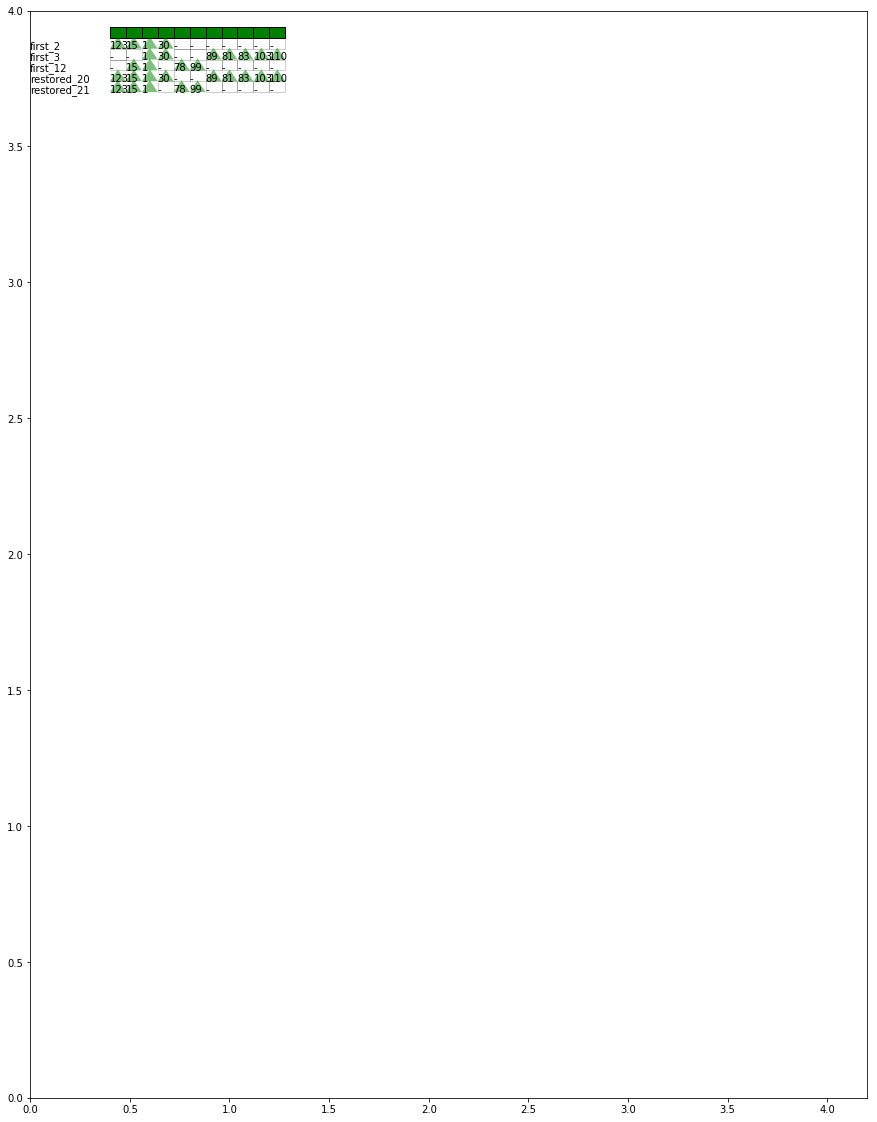

In [291]:
idx = 3
arrs = [x for x in ca.restore_arrays_all(pred_grs[idx])[0] if len(x) > 1]
arrs_gr = [x for x in  ca.restore_arrays_greedy(grs[idx], 25)[0] if len(x) > 1]

arrs_keys = dict(zip([tuple(x) for x in arrs],np.arange(len(arrs))))
arrs_gr_keys = dict(zip([tuple(x) for x in arrs_gr],np.arange(len(arrs_gr))))

fig, ax = plt.subplots(1, figsize = (15,1 * len (answer_ids_fixed[idx][0])))
ax.set_xlim(0,4.2)
ax.set_ylim(0,0.2 * len(answer_ids_fixed[idx][0]))
y0 = len(answer_ids_fixed[idx][0]) * 0.2 - 0.1

seen_keys = set()
for k,v in list(answer_ids_fixed[idx][0].items())[:1]:

    if not k in seen_keys:
        candidates = dict()
        for key, val in answer_ids_fixed[3][0].items():
            candidates[key] = val 
        for i, a in enumerate(arrs):
            candidates['restored_' + str(i)] = a
        alignments = ca.water_alignments_dict(v, candidates) 

        aligned_alignments = [list(x[1]) for x in alignments.values()]
    
        links, arrs_np = get_links(aaa)
        new_arrs = align(aaa, arrs_np, links)
        combined = create_combined_array(new_arrs)
        
        y_tmp = draw_allignment(ax, combined, new_arrs, ' ', keys, cmap, 0.4, y0)
        
        seen_keys.add(k)
        for key in keys:
            seen_keys.add(key)


    y0 = y_tmp
    y0 -= 0.05
#plt.show()

In [106]:
seen_keys

{'first_12',
 'first_2',
 'first_21',
 'first_27',
 'first_3',
 'first_5',
 'first_65',
 'first_7',
 'first_8',
 'first_9',
 'restored_0',
 'restored_10',
 'restored_11',
 'restored_12',
 'restored_13',
 'restored_14',
 'restored_15',
 'restored_16',
 'restored_17',
 'restored_18',
 'restored_19',
 'restored_20',
 'restored_21',
 'restored_22',
 'restored_23',
 'restored_25',
 'restored_3',
 'restored_4',
 'restored_5',
 'restored_6',
 'restored_7',
 'restored_8',
 'restored_9',
 'second_12',
 'second_2',
 'second_21',
 'second_27',
 'second_3',
 'second_5',
 'second_65',
 'second_7',
 'second_8',
 'second_9'}

In [110]:
for k, v in candidates.items():
    if not k in seen_keys:
        print(k, v)

restored_1 [24, 2, 4, 10, 69, 66, 52, 79, 84, 23, 0, 57, 64, 46, 87]
restored_2 [24, 2, 4, 48, 73, 56, 10, 69, 66, 52, 79, 84, 23, 0, 57, 64, 46, 87]
restored_24 [127, 129]
restored_26 [132, 134]


# Отрисуем дерево развешенное


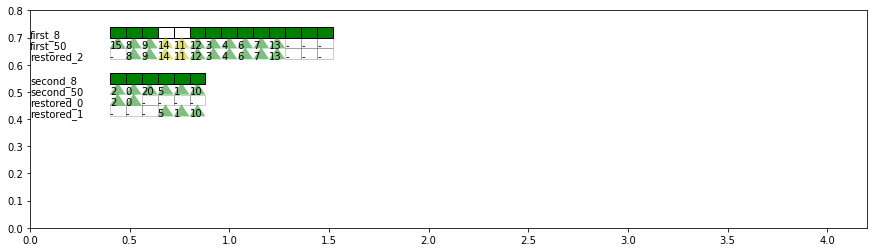

In [117]:
idx = 2
arrs = [x for x in ca.restore_arrays_all(pred_grs[idx])[0] if len(x) > 1]
arrs_gr = [x for x in  ca.restore_arrays_greedy(grs[idx], 25)[0] if len(x) > 1]

arrs_keys = dict(zip([tuple(x) for x in arrs],np.arange(len(arrs))))
arrs_gr_keys = dict(zip([tuple(x) for x in arrs_gr],np.arange(len(arrs_gr))))

fig, ax = plt.subplots(1, figsize = (15,1 * len (answer_ids_fixed[idx][0])))
ax.set_xlim(0,4.2)
ax.set_ylim(0,0.2 * len(answer_ids_fixed[idx][0]))
y0 = len(answer_ids_fixed[idx][0]) * 0.2 - 0.1

seen_keys = set()
for k,v in answer_ids_fixed[idx][0].items():

    if not k in seen_keys:
        candidates = dict()
        for key, val in answer_ids_fixed[idx][0].items():
            candidates[key] = val 
        for i, a in enumerate(arrs):
            candidates['restored_' + str(i)] = a
        alignments = ca.water_alignments_dict(v, candidates) 
        keys = [x for x in alignments.keys()]
        alignments_list = [alignments[k] for k in keys]
        aligned_seqs = ca.process_multiple_alignments(alignments_list)
        s, t =  ca.preprint_multiple_alignments(aligned_seqs)   
        y_tmp = draw_allignment(ax, s, t, k, keys, cmap, 0.4, y0)
        
        seen_keys.add(k)
        for key in keys:
            seen_keys.add(key)


#     candidates = answer_ids_fixed[3][0]
#     for i, a in enumerate(arrs_gr):
#         candidates['restored_' + str(i)] = a
#     alignments = ca.water_alignments_dict(v, candidates) 
#     keys = [x for x in alignments.keys()]
#     alignments_list = [alignments[k] for k in keys]
#     #keys = [arrs_keys[tuple(x[1])] for x in alignments]
#     aligned_seqs = ca.process_multiple_alignments(alignments_list)
#     s, t =  ca.preprint_multiple_alignments(aligned_seqs)  
#     _ = draw_allignment(ax, s, t, k, keys, cmap, 2.2 + 0.4, y0)
    y0 = y_tmp
    y0 -= 0.05
#plt.show()

In [ ]:
seen = set()
for key in answer_ids_fixed[3][0].keys():
    print('+++++++++++++++', key)

    base = answer_ids_fixed[3][0][key]
    
    if tuple(base) in seen:
        pass
    else:
        candidates = answer_ids_fixed[3][0]
        for i, a in enumerate(arrs):
            candidates['restored_' + str(i)] = a
        
        #print(len(candidates))

        alignments = ca.water_alignments_dict(base, candidates)
        keys = [x for x in alignments.keys()]
        alignments_list = [alignments[k] for k in keys]
        aligned_seqs = ca.process_multiple_alignments(alignments_list)
        s, t =  preprint_multiple_alignment(aligned_seqs)

        #print(preprint_seq(s))
        for t_, k in zip(t, keys):
            print(k, ca.preprint_seq(t_))
        
        seen.add(tuple(base))
        for a in alignments:
            seen.add(tuple(a[0]))
            seen.add(tuple(a[1]))
    

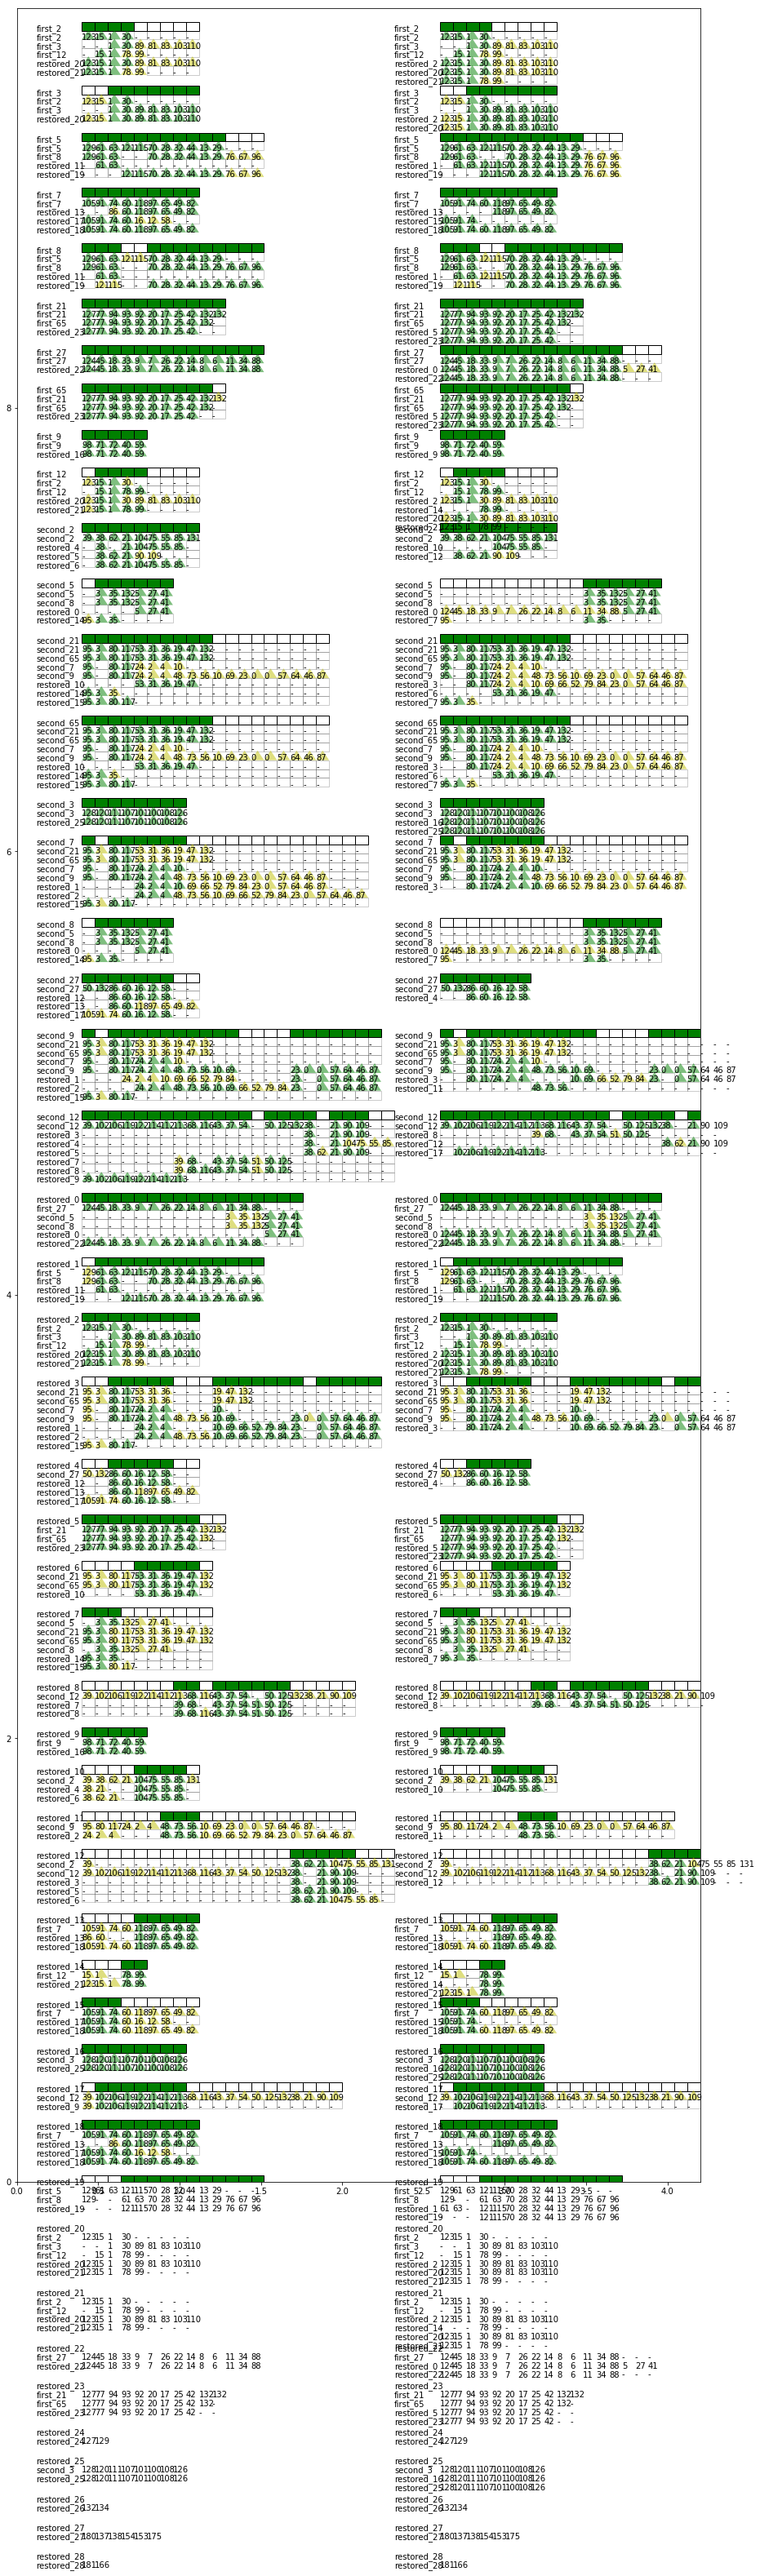

In [76]:
idx = 3
arrs = [x for x in ca.restore_arrays_all(pred_grs[idx])[0] if len(x) > 1]
arrs_gr = [x for x in  ca.restore_arrays_greedy(grs[idx], 25)[0] if len(x) > 1]

arrs_keys = dict(zip([tuple(x) for x in arrs],np.arange(len(arrs))))
arrs_gr_keys = dict(zip([tuple(x) for x in arrs_gr],np.arange(len(arrs_gr))))

fig, ax = plt.subplots(1, figsize = (15,1 * len (answer_ids_fixed[idx][0])))
ax.set_xlim(0,4.2)
ax.set_ylim(0,0.2 * len(answer_ids_fixed[idx][0]))
y0 = len(answer_ids_fixed[idx][0]) * 0.2 - 0.1

for k,v in answer_ids_fixed[idx][0].items():
    #v= list(answer_ids_fixed[3 ][0]['first_2'])
    candidates = answer_ids_fixed[3][0]
    for i, a in enumerate(arrs):
        candidates['restored_' + str(i)] = a
    alignments = ca.water_alignments_dict(v, candidates) 
    keys = [x for x in alignments.keys()]
    alignments_list = [alignments[k] for k in keys]
    #keys = [arrs_keys[tuple(x[1])] for x in alignments]
    aligned_seqs = ca.process_multiple_alignments(alignments_list)
    s, t =  ca.preprint_multiple_alignments(aligned_seqs)   
    y_tmp = draw_allignment(ax, s, t, k, keys, cmap, 0.4, y0)
    #y0 -= 0.05

    candidates = answer_ids_fixed[3][0]
    for i, a in enumerate(arrs_gr):
        candidates['restored_' + str(i)] = a
    alignments = ca.water_alignments_dict(v, candidates) 
    keys = [x for x in alignments.keys()]
    alignments_list = [alignments[k] for k in keys]
    #keys = [arrs_keys[tuple(x[1])] for x in alignments]
    aligned_seqs = ca.process_multiple_alignments(alignments_list)
    s, t =  ca.preprint_multiple_alignments(aligned_seqs)  
    _ = draw_allignment(ax, s, t, k, keys, cmap, 2.2 + 0.4, y0)
    y0 = y_tmp
    y0 -= 0.05
#plt.show()

In [62]:
idx = 3
arrs = [x for x in ca.restore_arrays_all(pred_grs[idx])[0] if len(x) > 1]
arrs_gr = [x for x in  ca.restore_arrays_greedy(grs[idx], 25)[0] if len(x) > 1]


In [63]:
seen = set()
for key in answer_ids_fixed[3][0].keys():
    print('+++++++++++++++', key)

    base = answer_ids_fixed[3][0][key]
    
    if tuple(base) in seen:
        pass
    else:
        candidates = [x for x in answer_ids_fixed[3][0].values()] +  arrs
        
        #print(len(candidates))

        alignments = ca.water_alignments(base, candidates)
        aligned_seqs = process_alignments(alignments)
        s, t =  preprint_multiple_alignment(aligned_seqs)

        #print(preprint_seq(s))
        for t_ in t:
            print(preprint_seq(t_))
        
        seen.add(tuple(base))
        for a in alignments:
            seen.add(tuple(a[0]))
            seen.add(tuple(a[1]))
    

+++++++++++++++ first_2
 123, 15 , 1  , 30 , -  , -  , -  , -  , -  ,
 -  , -  , 1  , 30 , 89 , 81 , 83 , 103, 110,
 -  , 15 , 1  , 78 , 99 , -  , -  , -  , -  ,
 123, 15 , 1  , 30 , 89 , 81 , 83 , 103, 110,
 123, 15 , 1  , 78 , 99 , -  , -  , -  , -  ,
+++++++++++++++ first_3
+++++++++++++++ first_5
 129, 61 , 63 , 121, 115, 70 , 28 , 32 , 44 , 13 , 29 , -  , -  , -  ,
 129, 61 , 63 , -  , -  , 70 , 28 , 32 , 44 , 13 , 29 , 76 , 67 , 96 ,
 -  , 61 , 63 , -  , -  , -  , -  , -  , -  , -  , -  , -  , -  , -  ,
 -  , -  , -  , 121, 115, 70 , 28 , 32 , 44 , 13 , 29 , 76 , 67 , 96 ,
+++++++++++++++ first_7
 105, 91 , 74 , 60 , 118, 97 , 65 , 49 , 82 ,
 -  , -  , 86 , 60 , 118, 97 , 65 , 49 , 82 ,
 105, 91 , 74 , 60 , 16 , 12 , 58 , -  , -  ,
 105, 91 , 74 , 60 , 118, 97 , 65 , 49 , 82 ,
+++++++++++++++ first_8
+++++++++++++++ first_21
 127, 77 , 94 , 93 , 92 , 20 , 17 , 25 , 42 , 132, 132,
 127, 77 , 94 , 93 , 92 , 20 , 17 , 25 , 42 , 132, -  ,
 127, 77 , 94 , 93 , 92 , 20 , 17 , 25 , 42 ,

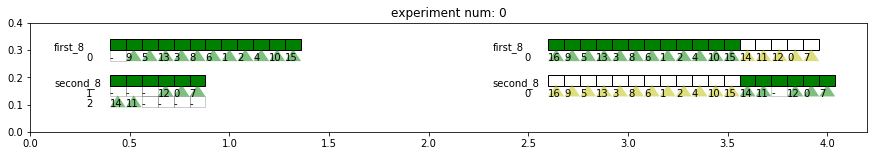

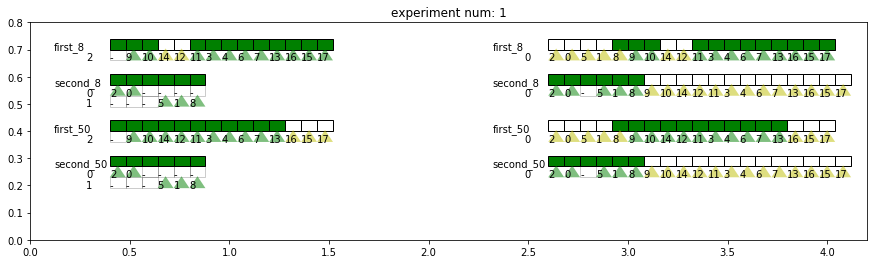

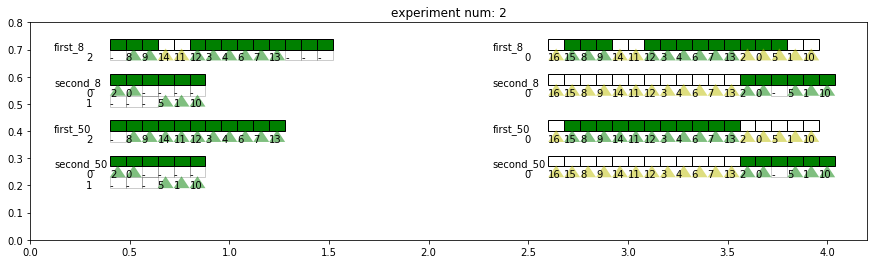

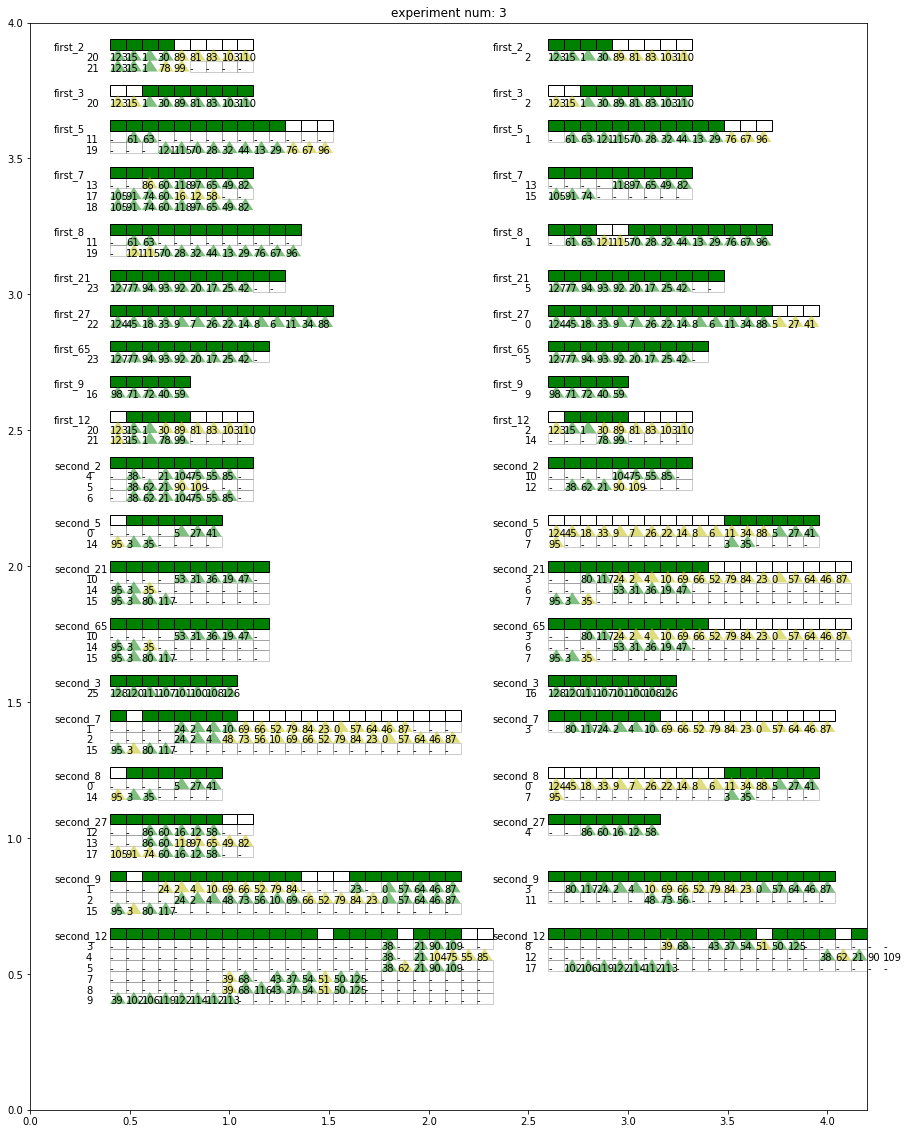

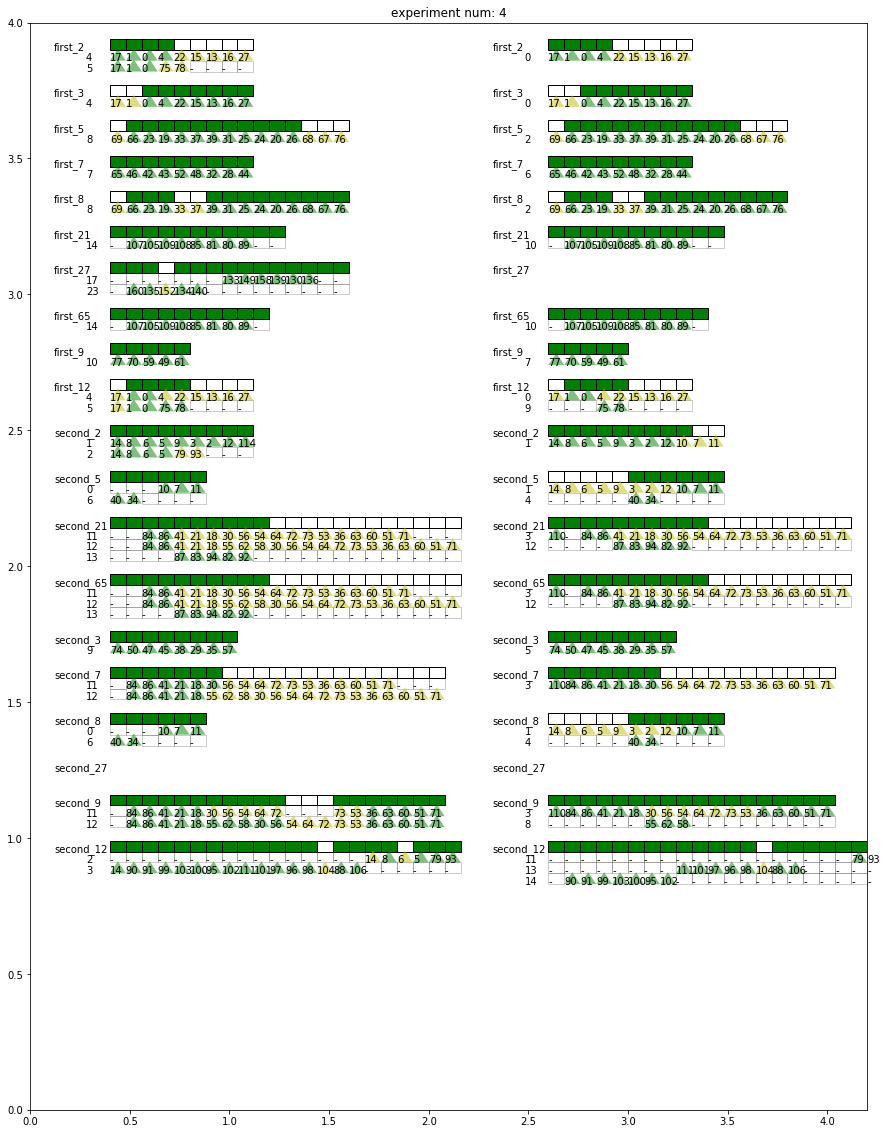

In [91]:
for idx in range(5):
    arrs = [x for x in ca.restore_arrays_all(pred_grs[idx])[0] if len(x) > 1]
    arrs_gr = [x for x in  ca.restore_arrays_greedy(grs[idx], 25)[0] if len(x) > 1]

    arrs_keys = dict(zip([tuple(x) for x in arrs],np.arange(len(arrs))))
    arrs_gr_keys = dict(zip([tuple(x) for x in arrs_gr],np.arange(len(arrs_gr))))

    fig, ax = plt.subplots(1, figsize = (15,1 * len (answer_ids_fixed[idx][0])))
    ax.set_xlim(0,4.2)
    ax.set_ylim(0,0.2 * len(answer_ids_fixed[idx][0]))
    y0 = len(answer_ids_fixed[idx][0]) * 0.2 - 0.1

    for k,v in answer_ids_fixed[idx][0].items():
        #v= list(answer_ids_fixed[3 ][0]['first_2'])
        alignments = ca.water_alignments(v, arrs)
        keys = [arrs_keys[tuple(x[1])] for x in alignments]
        aligned_seqs = process_alignments(alignments)
        s, t =  preprint_multiple_alignment(aligned_seqs)   
        y_tmp = draw_allignment(ax, s, t, k, keys, cmap, 0.4, y0)
        #y0 -= 0.05

           #v= list(answer_ids_fixed[3][0]['first_2'])
        alignments = ca.water_alignments(v, arrs_gr)
        keys = [arrs_gr_keys[tuple(x[1])] for x in alignments]
        aligned_seqs = process_alignments(alignments)
        s, t =  preprint_multiple_alignment(aligned_seqs)   
        _ = draw_allignment(ax, s, t, k, keys, cmap, 2.2 + 0.4, y0)
        y0 = y_tmp
        y0 -= 0.05

    ax.set_title("experiment num: " + str(idx))
    fig.savefig("../../article/pics/alignment/fig_" + str(idx) + ".png", format='png')

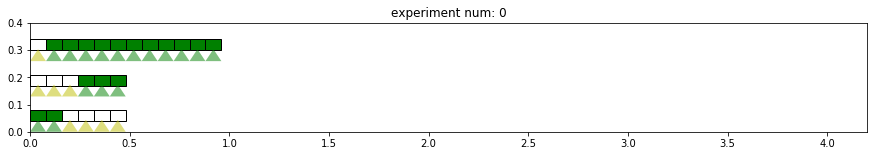

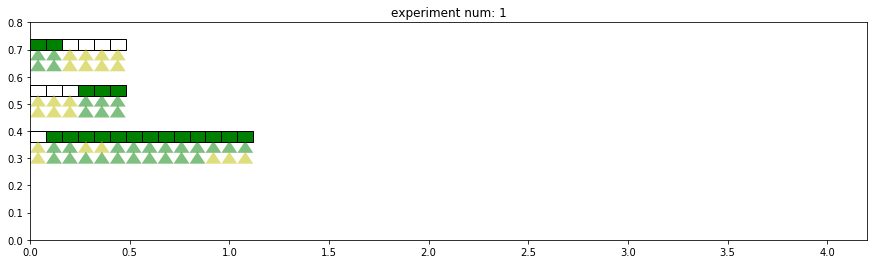

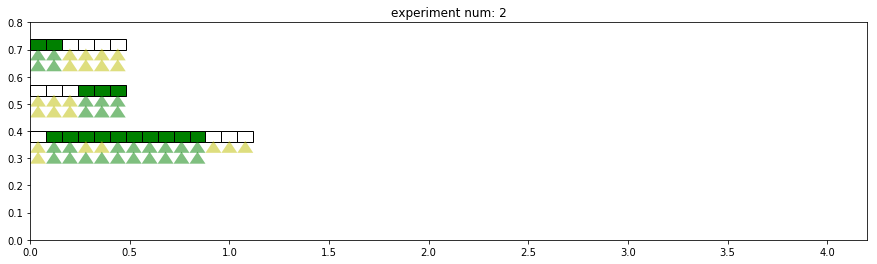

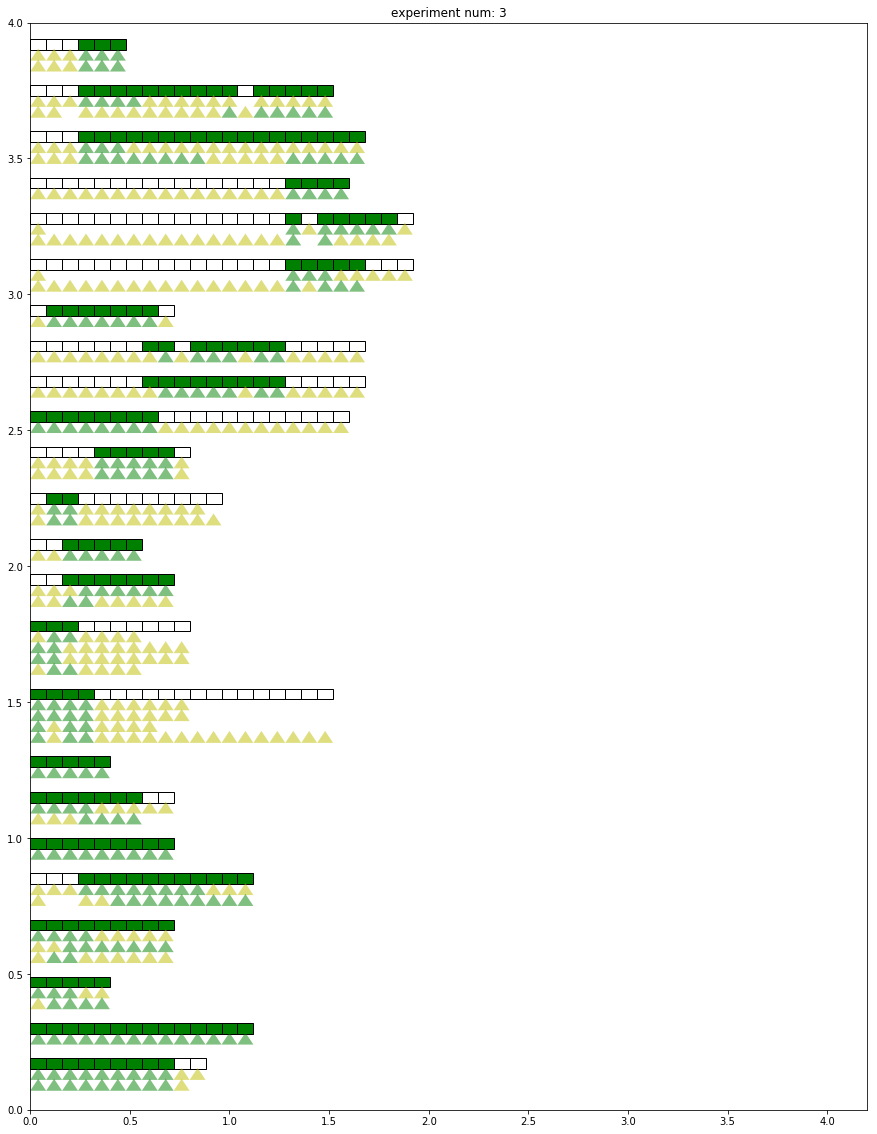

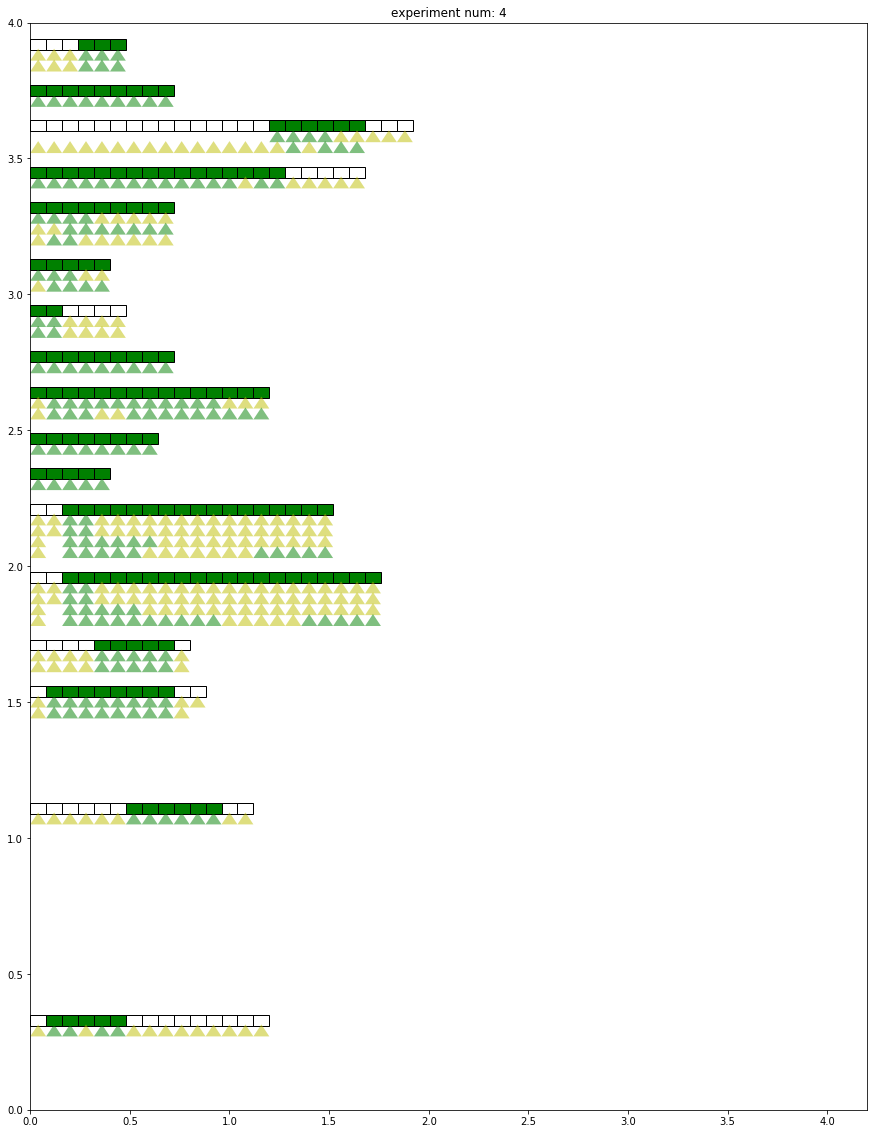

In [84]:
for idx in range(5):
    arrs = [x for x in ca.restore_arrays_all(pred_grs[idx])[0] if len(x) > 1]
    arrs_gr = [x for x in  ca.restore_arrays_greedy(grs[idx], 25)[0] if len(x) > 1]

    fig, ax = plt.subplots(1, figsize = (15,1 * len (answer_ids_fixed[idx][0])))
    ax.set_xlim(0,4.2)
    ax.set_ylim(0,0.2 * len(answer_ids_fixed[idx][0]))
    y0 = len(answer_ids_fixed[idx][0]) * 0.2 - 0.1

    for v in arrs:
        #v= list(answer_ids_fixed[3 ][0]['first_2'])
        alignments = ca.water_alignments(v, [x for x in answer_ids_fixed[idx][0].values()])
        aligned_seqs = process_alignments(alignments)
        s, t =  preprint_multiple_alignment(aligned_seqs)   
        y0 = draw_allignment(ax, s, t, cmap, 0, y0)
        y0 -= 0.05

#            #v= list(answer_ids_fixed[3][0]['first_2'])
#         alignments = ca.water_alignments(v, arrs_gr)
#         aligned_seqs = process_alignments(alignments)
#         s, t =  preprint_multiple_alignment(aligned_seqs)   
#         _ = draw_allignment(ax, s, t, cmap, 2, y0)

#     #plt.show()

    ax.set_title("experiment num: " + str(idx))
    fig.savefig("../../article/pics/alignment/reverse/fig_" + str(idx) + ".png", format='png')

In [86]:
arrs

[[9, 5, 13, 3, 8, 6, 1, 2, 4, 10, 15], [12, 0, 7], [14, 11]]

In [88]:
[x for x in answer_ids_fixed[idx][0].values()]

[array([18,  9, 10, 11,  3,  4,  6,  7, 13, 16, 15, 17]),
 array([ 2,  0, 19,  5,  1,  8]),
 array([18,  9, 10, 14, 12, 11,  3,  4,  6,  7, 13]),
 array([ 2,  0, 19,  5,  1,  8])]

In [89]:
t

[[18, 9, 10, '-', '-', 11, 3, 4, 6, 7, 13, 16, 15, 17],
 [18, 9, 10, 14, 12, 11, 3, 4, 6, 7, 13, '-', '-', '-']]

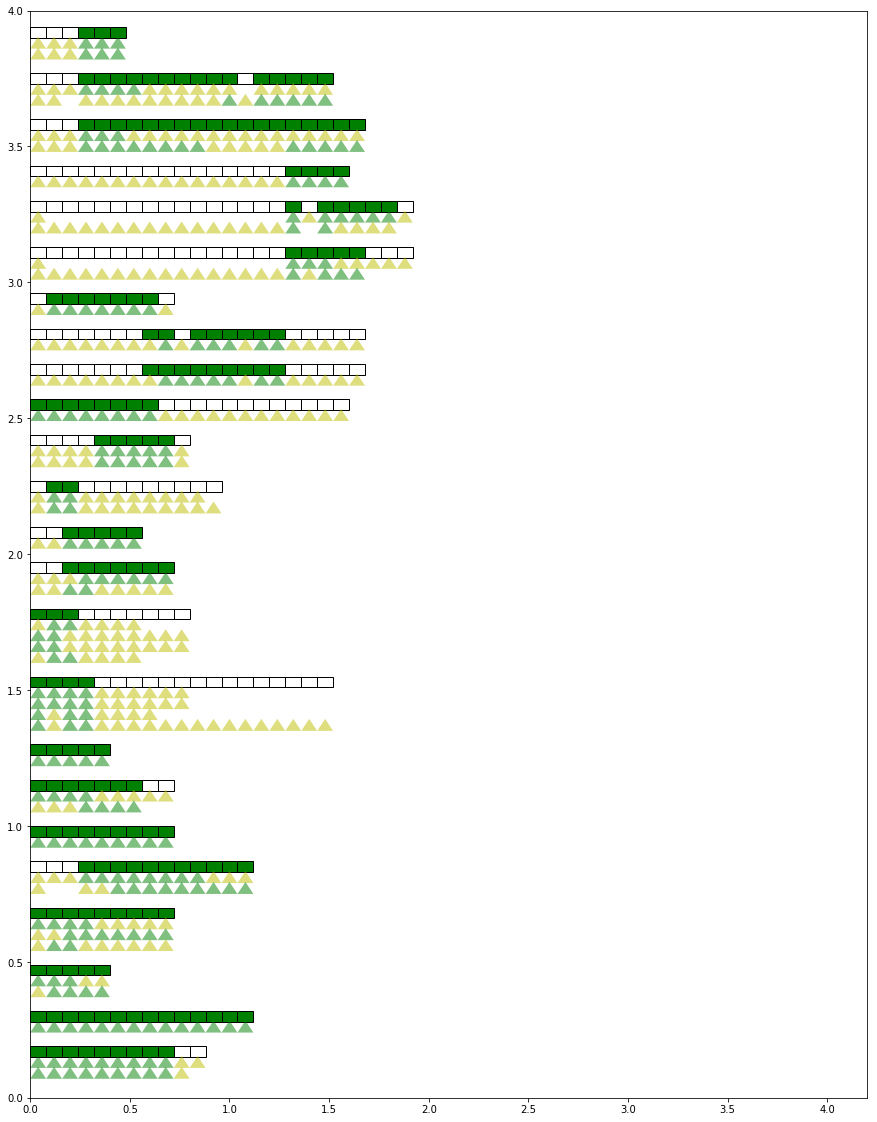

In [91]:
idx = 3
arrs = [x for x in ca.restore_arrays_all(pred_grs[idx])[0] if len(x) > 1]
arrs_gr = [x for x in  ca.restore_arrays_greedy(grs[idx], 25)[0] if len(x) > 1]

fig, ax = plt.subplots(1, figsize = (15,1 * len (answer_ids_fixed[idx][0])))
ax.set_xlim(0,4.2)
ax.set_ylim(0,0.2 * len(answer_ids_fixed[idx][0]))
y0 = len(answer_ids_fixed[idx][0]) * 0.2 - 0.1

for v in arrs:
    #v= list(answer_ids_fixed[3 ][0]['first_2'])
    alignments = ca.water_alignments(v, [x for x in answer_ids_fixed[idx][0].values()])
    aligned_seqs = process_alignments(alignments)
    s, t =  preprint_multiple_alignment(aligned_seqs)   
    y0 = draw_allignment(ax, s, t, cmap, 0, y0)
    y0 -= 0.05

plt.show()

#            #v= list(answer_ids_fixed[3][0]['first_2'])
#         alignments = ca.water_alignments(v, arrs_gr)
#         aligned_seqs = process_alignments(alignments)
#         s, t =  preprint_multiple_alignment(aligned_seqs)   
#         _ = draw_allignment(ax, s, t, cmap, 2, y0)

#     #plt.show()

# ax.set_title("experiment num: " + str(idx))
# fig.savefig("../../article/pics/alignment/reverse/fig_" + str(idx) + ".png", format='png')

In [575]:
plt.savefig("/home/anton/322.pdf")


In [335]:
125 * 16 %150

50

In [95]:
res[0].index_to_cluster.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58])

In [100]:
#merged_cluster_to_index = {}
smth = {}

for i in range(grs[0].shape[0])[:-2]:
    cluster = res[0].index_to_cluster[i]
    #print(res[1].cluster_to_index[ca.find_closest(res[1].cluster_to_index, cluster)[1]])
    smth[i] = res[1].cluster_to_index[ca.find_closest(res[1].cluster_to_index, cluster)[1]]

In [117]:
def rearrange_graph(gr, order):
    new_gr = np.zeros((100,100))
    
    for i in range(gr.shape[0] - 4):
        for j in range(gr.shape[1] - 4):
            new_gr[order[i], order[j]] = gr[i,j]
        
    return new_gr

In [82]:
a[1]

({'first_11': [35, 31, 27, 30, 32, 28, 33],
  'first_22': [17, 11, 4, 14, 5, 1, 10, 15],
  'second_11': [23, 22, 21, 26, 34],
  'second_22': [6, 3, 0, 2, 7, 12, 13, 9, 16]},
 {'first_11': [2, 0, 0, 0, 0, 0, 0],
  'first_22': [0, 0, 0, 0, 0, 0, 0, 0],
  'second_11': [0, 0, 0, 0, 0],
  'second_22': [0, 1, 0, 0, 0, 0, 0, 0, 0]})

In [94]:
ca.graph_from_arrays([[1,2], [3,4]])

(array([[0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0]]), 0)

In [98]:
grs_answ = [ca.graph_from_arrays([x for x in x[0].values()], 50)[0][:50, :50] for x in a]

In [108]:
grs_restored = [ca.graph_from_arrays([x for x in x[0]], 50)[0][:50, :50] for x in restored]

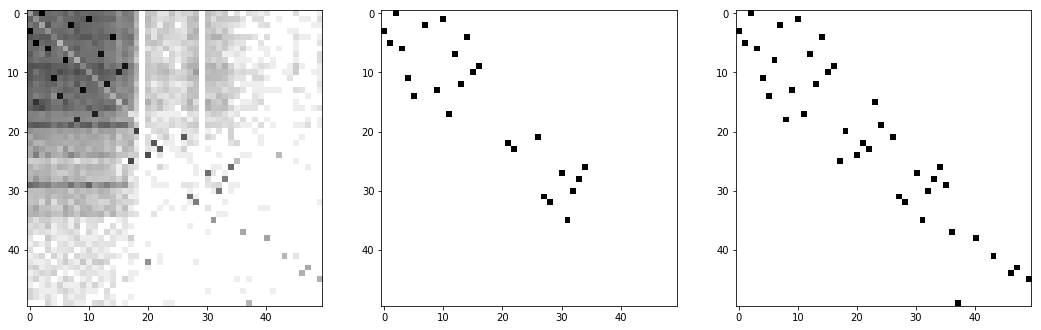

In [112]:
ca.plot_grs(grs[1][:50, :50], grs_answ[1], grs_restored[1], s=18,  log=1)

In [101]:
def calc_noise_ratio(gr0, gr):
    return  gr[gr0 > 0].sum() / gr.sum()

In [114]:
calc_noise_ratio(grs_restored[1], grs[1][:50,:50])

0.7008704988401351

In [119]:
a[0][0]['first_22']

[17, 16, 14, 15, 7, 1, 2, 13]

In [128]:
def calc_array_mean_noise(gr, array):
    total = gr[array][:, array].sum()
    
    total -= np.diag(gr[array][:, array], 1).sum()
    
    return total / (len(array) * (len(array) - 1))

In [129]:
def calc_mean_noise_between(gr, array_1, array_2):
    total = 0
    for i in array_1:
        for j in array_2:
            total += gr[i][j]
            
    return total / (len(array_1) * len(array_2))

In [133]:
idx = 1

In [134]:
print(calc_array_mean_noise(grs[idx], a[idx][0]['first_22']), 
    calc_array_mean_noise(grs[idx], a[idx][0]['second_22']),
      calc_mean_noise_between(grs[idx], a[idx][0]['first_22'], a[idx][0]['second_22']))

344.3392857142857 388.9583333333333 439.31944444444446


In [135]:
print(calc_array_mean_noise(grs[idx], a[idx][0]['first_11']), 
    calc_array_mean_noise(grs[idx], a[idx][0]['second_11']),
      calc_mean_noise_between(grs[idx], a[idx][0]['first_11'], a[idx][0]['second_11']))

0.3333333333333333 1.55 0.14285714285714285


In [122]:
grs[0][a[0][0]['first_22']][:, a[0][0]['first_22']]

array([[   1,  615,    1,    2,    0,    2,    6,    4],
       [   0,    1, 1434,   17,    1,    7,   16,    7],
       [   0,    3,    0, 2476,    5,    7,   18,    4],
       [   0,    3,    3,    1, 2037,   14,   23,   16],
       [   2,   15,    7,   15,    0, 6118,   30,    7],
       [   4,   18,    9,   33,   13,   12, 8116,   23],
       [   3,    6,   10,   17,   15,    6,    6, 3148],
       [   0,    5,    2,    1,    1,   79,    4,    0]])

In [23]:
ca.plot_grs(rearrange_graph(grs[0], smth)[:50, :50], grs[1][:50, :50], log = 1, s = 12)

NameError: name 'rearrange_graph' is not defined

In [131]:
for i in range(80):
    print(res[0].index_to_cluster[i], res[1].index_to_cluster[smth[i]], ed.eval(res[0].index_to_cluster[i], res[1].index_to_cluster[smth[i]]))

GGGTTGACGCCAGCGAACATTGACTCAGA GGGTTGACGCCAGCGAACATTGACTCAGA 0
AATGCATCAGTTGAACACAAAAGTAGCTT AATGCATCAGTTGAACACAAAAGTAGCTT 0
TAAACCACCAGCCAGACCACCAATTACCAC TAAACCACCAGCCAGACCACCAATTACCA 1
GTAACGTGGCGACGACCGGCGATTGATTT GTAACGTGGCGACGACCGGCGATTGATTT 0
TCGAACCTGTTTTTCTTAGTGCGCGCAAC TCGAACCTGTTTTTCTTAGTGCGCGCAAC 0
TACAGTTAAGCGTAAAGTAAGTGATACTGG TACAGTTAAGCGTAAAGTAAGTGATACTG 1
GTTGTTGTAATAAAGCCCCGGAGTTTTAT GTTGTTGTAATAAAGCCCCGGAGTTTTAT 0
TGAGCGTCGGCGGCTCGCTGGATTTGCG TGAGCGTCGGCGGCTCGCTGGATTTGCG 0
GTCGCCGGGTTGATTTTCCATGATGATTT GTCGCCGGGTTGATTTTCCATGATGATTT 0
CGTCCGGATCGGTTTCGAGAATCTCTACG CGTCCGGATCGGTTTCGAGAATCTCTACG 0
GTTTTCATTTGCACGAGCTGCACCATAAGA GTTTTCATTTGCACGAGCTGCACCATAAG 1
GTTATCACCGAGTGCAGTAGCCCGCGCGC GTTATCACCGAGTGCAGTAGCCCGCGCGC 0
GCCCGCCTCGTCGGTGTATTCCGCGAGAT GCCCGCCTCGTCGGTGTATTCCGCGAGAT 0
GCGATGGATCAGGGTATTACACTCGACGGC GCGATGGATCAGGGTATTACACTCGACGG 1
GGAATGATATTTCAATAAATAATTATAAC GGAATGATATTTCAATAAATAATTATAAC 0
TTTTTGTTAATTGCGTTTGCCACGGTTTG TTTTTGTTAATTGCGTTTGCCACGGTTTG 0
AGTGCT

In [85]:
def merge_ordered(s1, threshold = 2):
    s = []
    for el in s1:
        found = ca.find_closest(s, el)
        if found[1] > threshold:
            s.append(el)
    
    return s

In [69]:
gr = np.dot(np.ones((3,1)), np.arange(3).reshape(1,3))

In [70]:
merge_ordered(res[0].spacers.union(res[1].spacers))

StopIteration: 

In [32]:
a[0]

{'first_11': [44, 20, 19, 21, 27, 24, 25],
 'first_2': [47, 50, 13, 9, 30],
 'first_3': [9, 20, 9, 19, 9, 47, 42],
 'first_5': [7, 0, 20, 28, 38, 13, 9, 35, 34, 7, 13],
 'first_7': [47, 34, 18, 5, 11, 32, 57, 0, 0, 19],
 'first_8': [7, 0, 20, 13, 9, 35, 34, 7, 13, 1, 51, 7],
 'first_14': [17, 16, 14, 15, 7, 1, 0, 41, 2, 26, 26, 24],
 'first_15': [44, 20, 19, 4, 21, 27, 0, 6, 8, 29, 24, 25],
 'first_22': [17, 16, 14, 15, 7, 1, 2, 13],
 'first_21': [47, 34, 18, 5, 11, 32, 57, 0, 0, 19, 15],
 'second_2': [32, 35, 37, 3, 11, 1, 13, 2, 22],
 'second_5': [9, 18, 11, 2, 57, 15],
 'second_21': [29, 1, 22, 26, 12, 15, 6, 3, 18, 18],
 'second_3': [44, 0, 0, 1, 4, 1, 20, 36],
 'second_7': [29, 22, 26, 8, 45, 22, 0],
 'second_8': [58, 18, 40, 28, 14, 3],
 'second_11': [32, 28, 31, 34, 43],
 'second_14': [32, 18, 4, 18, 16, 5, 24, 13, 30, 7, 33, 7, 32],
 'second_15': [32, 18, 28, 31, 34, 12],
 'second_22': [11, 8, 3, 4, 9, 6, 0, 5, 10]}

In [24]:
restored = [ca.restore_arrays(x) for x in grs]

In [5]:
rep = 'CGGTTTATCCCCGCTGGCGCGGGGAACAC'
s = rep.join(answer_sensivity['first_11'])

In [7]:
s[:100]

'AAAACCAAACTTCTCCATAAATTCCATAGCCGCGGTTTATCCCCGCTGGCGCGGGGAACACGAGTCTATCAGCGACACTACCGGCAATAGCGACGGTTTA'

In [74]:
struct = '....(((....................((((((((((...((((((....))))))................................\
.............((((((....))))))........((((((..........))))))..))))))))))..(((((((....)))))))\
............................................((((((....))))))....((((........(((((((((.....(((\
(((((((.......)))))))))).))))))))).......))))...........................(((((((....)))))))....\
..............................)))'

In [69]:
import regex as re

In [76]:
for split in [x.span() for x in re.finditer(rep, s)]: 
    print(struct[split[0]:split[1]])

(((((...((((((....)))))).....
........((((((....)))))).....
)))))..(((((((....)))))))....
........((((((....))))))....(
(((.......)))))))))).))))))))
.......(((((((....)))))))....


In [79]:
get_weights(grs[0], [a[0][0]['first_11']])

[[21, 150, 163, 57, 70, 76]]

In [30]:
def search_ays_in_b(a, b, gr):
    res = []
    for a_name, a_array in a.items():
        matched_parts, b_name, positions = ca.search_best_alignment(
            a_array,
            b)

        res.append(ca.Match(a_name,
             b_name,
             len(matched_parts[0]) / len(a_array),
             len(matched_parts[1]) / len(b[b_name]),
             a_array,
             b[b_name],
             get_weights(gr, [a_array]),
             get_weights(gr, [b[b_name]])))
        
        res[-1].print()
    
    return res

In [49]:
answer_sensivity

{'first_11': ['AAAACCAAACTTCTCCATAAATTCCATAGCCG',
  'GAGTCTATCAGCGACACTACCGGCAATAGCGA',
  'CTATAGCGCCACGTTCCGAGCGCTGCGAGCTG',
  'CTAATGAGTCAGTTTGAACAGATCCCCGACAA',
  'GGCTTTAAAATTGTGTTCCCGTCTGGCGCTGG',
  'GCATCCATGCCGACGCCTTTACGTGTGCGGGG',
  'GCGCGAATTTGTGCGCATGGGGCGCATTTTTGG'],
 'first_2': ['TCTAAGTGATATCCATCATCGCATCCAGTGCGCC',
  'TCTTACTGCTTGGTATGCGGAATCACACCCTGAA',
  'ACTGAAGCATCAAACATTTGGTGGACCAAACGGA',
  'ACTGTACGCGGCGAGTTTTAGCGACAGGTCATCC',
  'ACGGATCTGCCAGCGCCTCTGCGGGGCGGTAAAC'],
 'first_3': ['GTACGCGGCGAGTTTTAGCGACAGGTCATCC',
  'GATCTGCCAGCGCCTCTGCGGGGCGGTAAAC',
  'ACGCCAGCCACCTGCTTCGCCAGCCGTTCGG',
  'CACGGTAGCGCCACTGCGCGTCGGTGACGGG',
  'ACGAACAGGGATTTGTCGGCAGTTTCTTTAC',
  'TAATTCGCAAATCAATATATATTTTGTCCGT',
  'ATTGCGGATGCTCCCGGAATTGCGCGGGCAA'],
 'first_5': ['CAGCGTCAGGCGTGAAATCTCACCGTCGTTGC',
  'TCGGTTCAGGCGTTGCAAACCTGGCTACCGGG',
  'GTAGTCCATCATTCCACCTATGTCTGAACTCC',
  'CCGGGGGATAATGTTTACGGTCATGCGCCCCC',
  'ATCGTCCATATTAACAATCGTGGTGAGTTCAA',
  'ACTATGGCCCCGGCAAAAAACGCGCTGGTGGG'

In [57]:
a[0]

{'first_11': [44, 20, 19, 21, 27, 24, 25],
 'first_2': [47, 50, 13, 9, 30],
 'first_3': [9, 20, 9, 19, 9, 47, 42],
 'first_5': [7, 0, 20, 28, 38, 13, 9, 35, 34, 7, 13],
 'first_7': [47, 34, 18, 5, 11, 32, 57, 0, 0, 19],
 'first_8': [7, 0, 20, 13, 9, 35, 34, 7, 13, 1, 51, 7],
 'first_14': [17, 16, 14, 15, 7, 1, 0, 41, 2, 26, 26, 24],
 'first_15': [44, 20, 19, 4, 21, 27, 0, 6, 8, 29, 24, 25],
 'first_22': [17, 16, 14, 15, 7, 1, 2, 13],
 'first_21': [47, 34, 18, 5, 11, 32, 57, 0, 0, 19, 15],
 'second_2': [32, 35, 37, 3, 11, 1, 13, 2, 22],
 'second_5': [9, 18, 11, 2, 57, 15],
 'second_21': [29, 1, 22, 26, 12, 15, 6, 3, 18, 18],
 'second_3': [44, 0, 0, 1, 4, 1, 20, 36],
 'second_7': [29, 22, 26, 8, 45, 22, 0],
 'second_8': [58, 18, 40, 28, 14, 3],
 'second_11': [32, 28, 31, 34, 43],
 'second_14': [32, 18, 4, 18, 16, 5, 24, 13, 30, 7, 33, 7, 32],
 'second_15': [32, 18, 28, 31, 34, 12],
 'second_22': [11, 8, 3, 4, 9, 6, 0, 5, 10]}

In [61]:
a[1][1]

{'first_11': [2, 0, 0, 0, 0, 0, 0],
 'first_2': [2, 13, 5, 5, 5],
 'first_3': [4, 4, 12, 12, 13, 13, 10],
 'first_5': [13, 13, 14, 14, 12, 15, 14, 14, 13, 3, 3],
 'first_7': [2, 3, 3, 3, 3, 3, 2, 3, 2, 2],
 'first_8': [13, 13, 14, 15, 14, 14, 13, 3, 3, 14, 3, 13],
 'first_14': [0, 0, 0, 0, 0, 0, 14, 13, 0, 13, 13, 15],
 'first_15': [2, 0, 0, 14, 0, 0, 13, 13, 14, 13, 0, 1],
 'first_22': [0, 0, 0, 0, 0, 0, 0, 0],
 'first_21': [2, 3, 3, 3, 3, 3, 2, 3, 2, 2, 11],
 'second_2': [0, 3, 3, 3, 13, 13, 3, 12, 14],
 'second_5': [3, 4, 4, 4, 5, 11],
 'second_21': [2, 3, 1, 1, 1, 3, 4, 4, 3, 3],
 'second_3': [13, 13, 12, 15, 12, 14, 13, 13],
 'second_7': [1, 0, 0, 12, 14, 14, 14],
 'second_8': [15, 15, 15, 13, 15, 14],
 'second_11': [0, 0, 0, 0, 0],
 'second_14': [0, 3, 12, 14, 3, 3, 12, 3, 3, 3, 14, 3, 4],
 'second_15': [0, 14, 0, 0, 0, 13],
 'second_22': [0, 1, 0, 0, 0, 0, 0, 0, 0]}

In [60]:
search_ays_in_b(a[1][0], dict(zip(np.arange(len(restored[1][0])), restored[1][0])), grs[1])

searched name: first_11
 found name: 2
 searched_overlap: 1.0
 found_overlap: 1.0
 arrs (search, found): 
[35, 31, 27, 30, 32, 28, 33]
[29, 35, 31, 27, 30, 32, 28, 33]
 weights (search, found):
[[61, 306, 341, 213, 193, 190]]
[[1, 61, 306, 341, 213, 193, 190]]
 _____________________

searched name: first_2
 found name: 14
 searched_overlap: 0.8
 found_overlap: 1.0
 arrs (search, found): 
[25, 64, 85, 78, 94]
[85, 78, 94]
 weights (search, found):
[[0, 0, 2, 1]]
[[2, 1]]
 _____________________

searched name: first_3
 found name: 14
 searched_overlap: 0.2857142857142857
 found_overlap: 1.0
 arrs (search, found): 
[78, 94, 97, 27, 7, 71, 29]
[85, 78, 94]
 weights (search, found):
[[1, 0, 0, 12, 0, 0]]
[[2, 1]]
 _____________________

searched name: first_5
 found name: 1
 searched_overlap: 0.2727272727272727
 found_overlap: 0.21428571428571427
 arrs (search, found): 
[5, 13, 31, 22, 40, 15, 7, 37, 26, 92, 98]
[25, 17, 11, 4, 14, 5, 1, 10, 15, 23, 22, 21, 26, 34]
 weights (search, found):

In [35]:
for key in a[0].keys():
    print(key, a[0][key])
    print(search_ays_in_b(a[0][key], dict(zip(np.arange(len(restored[0])), restored[0])), grs[0]))
    print("_____________________________________")

first_11 [44, 20, 19, 21, 27, 24, 25]


AttributeError: 'list' object has no attribute 'items'

In [29]:
a[0]

{'first_11': [44, 20, 19, 21, 27, 24, 25],
 'first_2': [47, 50, 13, 9, 30],
 'first_3': [9, 20, 9, 19, 9, 47, 42],
 'first_5': [7, 0, 20, 28, 38, 13, 9, 35, 34, 7, 13],
 'first_7': [47, 34, 18, 5, 11, 32, 57, 0, 0, 19],
 'first_8': [7, 0, 20, 13, 9, 35, 34, 7, 13, 1, 51, 7],
 'first_14': [17, 16, 14, 15, 7, 1, 0, 41, 2, 26, 26, 24],
 'first_15': [44, 20, 19, 4, 21, 27, 0, 6, 8, 29, 24, 25],
 'first_22': [17, 16, 14, 15, 7, 1, 2, 13],
 'first_21': [47, 34, 18, 5, 11, 32, 57, 0, 0, 19, 15],
 'second_2': [32, 35, 37, 3, 11, 1, 13, 2, 22],
 'second_5': [9, 18, 11, 2, 57, 15],
 'second_21': [29, 1, 22, 26, 12, 15, 6, 3, 18, 18],
 'second_3': [44, 0, 0, 1, 4, 1, 20, 36],
 'second_7': [29, 22, 26, 8, 45, 22, 0],
 'second_8': [58, 18, 40, 28, 14, 3],
 'second_11': [32, 28, 31, 34, 43],
 'second_14': [32, 18, 4, 18, 16, 5, 24, 13, 30, 7, 33, 7, 32],
 'second_15': [32, 18, 28, 31, 34, 12],
 'second_22': [11, 8, 3, 4, 9, 6, 0, 5, 10]}

In [25]:
restored[0][0]

[[18, 29, 22, 26, 12, 11, 8, 3, 4, 9, 6, 0, 5, 10],
 [47, 17, 16, 14, 15, 7, 1, 2, 13],
 [44, 20, 19, 21, 27, 24, 25],
 [32, 28, 31, 34, 43],
 [54, 46, 35, 36, 45, 48, 40, 33, 38, 37, 41, 39],
 [51, 55],
 [50, 52, 56]]

In [46]:
answ_gr = ca.graph_from_arrays([x for x in a.values()], 500)[0]

In [47]:
embs = make_vertexes_embs(gr)

In [48]:
graph_restored = gb.predict(embs[:, 1:]).reshape(gr.shape)

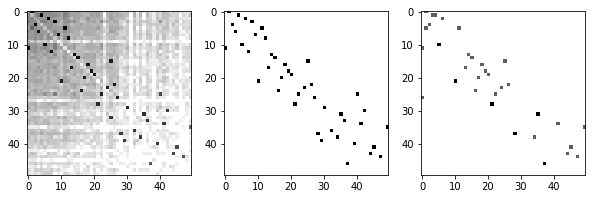

In [49]:
c1, c2, = 0, 50

ca.plot_grs(gr[c1:c2, c1:c2].astype(int),
            graph_restored[c1:c2, c1:c2],
            answ_gr[c1:c2, c1:c2],
            
            log = 1,
            s = 10)

In [50]:
restored_arrays = [x for x in restore_all(graph_restored) if len(x) > 1]
weights = get_weights(gr, restored_arrays)

In [51]:
for ra,wa  in zip(restored_arrays, weights):
    print(ra)
    print(wa)
    print("--------------------------------------------")

[23, 24, 16, 18, 19, 20, 17, 13, 14, 15, 25, 22, 26, 27]
[5491, 5550, 7881, 7389, 7254, 6007, 7294, 10495, 10251, 5448, 5456, 6225, 4275]
--------------------------------------------
[23, 24, 16, 18, 19, 20, 17, 13, 14, 15, 25, 22, 171]
[5491, 5550, 7881, 7389, 7254, 6007, 7294, 10495, 10251, 5448, 5456, 17]
--------------------------------------------
[23, 24, 16, 18, 19, 20, 17, 13, 14, 15, 25, 40, 39, 29, 30, 42]
[5491, 5550, 7881, 7389, 7254, 6007, 7294, 10495, 10251, 5448, 1200, 1845, 1732, 3795, 1857]
--------------------------------------------
[23, 24, 16, 18, 19, 20, 17, 13, 14, 15, 25, 40, 39, 29, 30, 196]
[5491, 5550, 7881, 7389, 7254, 6007, 7294, 10495, 10251, 5448, 1200, 1845, 1732, 3795, 5]
--------------------------------------------
[23, 24, 16, 18, 19, 20, 17, 13, 14, 15, 25, 159]
[5491, 5550, 7881, 7389, 7254, 6007, 7294, 10495, 10251, 5448, 37]
--------------------------------------------
[23, 24, 16, 18, 19, 20, 17, 13, 14, 15, 25, 188]
[5491, 5550, 7881, 7389, 7254

In [52]:
restored_arrays_filtered = [[23, 24, 16, 18, 19, 20, 17, 13, 14, 15, 25, 22, 26, 27],
                            [40, 39, 29, 30, 42],
                            [23, 94, 96, 101, 110, 130],
                            [23, 145, 149, 148, 153, 152, 177, 169, 200],
                            [31, 35, 49, 56, 50, 48, 58, 73, 76],
                            [80, 165, 174, 191],
                            [33, 36, 32],
                            [38, 34, 41, 45],
                            [46, 37, 28, 21, 10, 5, 11, 0, 1, 4, 2, 6, 3, 8, 12, 7, 9],
                            [70, 90, 69, 71, 68, 78, 89, 75, 83, 98],
                            [70, 118, 157, 150, 146, 166],
                            [85, 109, 112, 143, 144, 141, 139, 155, 170, 180],
                            [105, 66, 57, 43, 44, 47, 72],
                            [123, 99, 104, 106, 100, 108, 114, 124],
                            [127, 79, 67, 77, 81, 64, 55, 62, 60, 54, 59, 51, 53, 61, 65, 63, 74, 87, 92],
                            [197, 163, 95, 93, 82, 84, 91, 115, 117]]



In [53]:
restored_gr_filtered = ca.graph_from_arrays(restored_arrays_filtered, 500)[0]

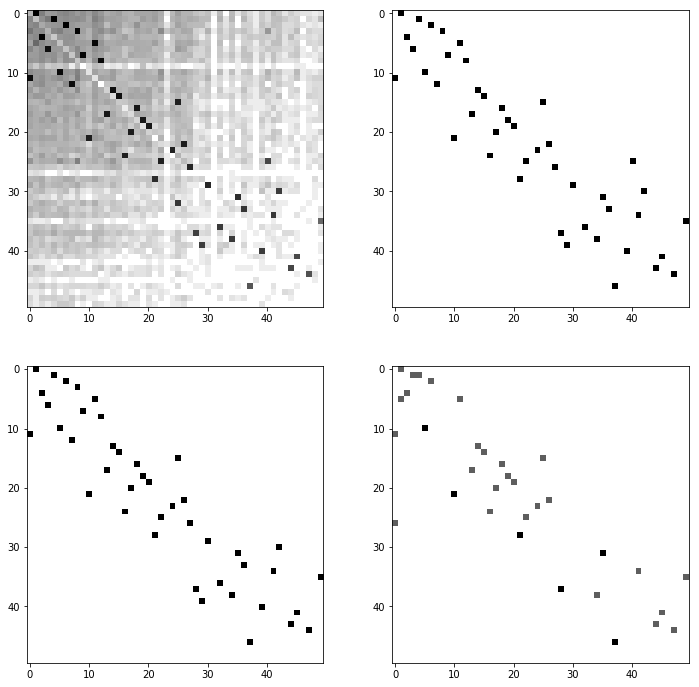

In [54]:
c1, c2, = 0, 50

ca.plot_grs(gr[c1:c2, c1:c2],
            graph_restored[c1:c2, c1:c2],
            restored_gr_filtered[c1:c2, c1:c2],
            answ_gr[c1:c2, c1:c2],
            
            log = 1,
            s = 12, 
            subplots_form = (2,2))

In [111]:
restored_gr_filtered[66,88]

0

In [55]:
restored_arrays_filtered_dict = dict(zip(np.arange(len(restored_arrays_filtered)), restored_arrays_filtered))

In [71]:
res.corrector.index_to_cluster[59]

'GCATCCATGCCGACGCCTTTACGTGTGCG'

In [72]:
res.corrector.index_to_cluster[55]

'GAGAGTGCTGACAGGTGTCTCGATTACCT'

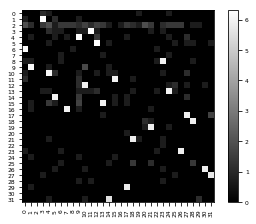

In [78]:
ca.plot_gr(gr[50:82, 50:82], all_ticks=1, log =1)

In [85]:
print(get_weights(gr, [[86, 31, 35, 50, 48, 58, 73, 76, 80, 165, 174, 191], [31, 35, 49, 56, 50, 48, 58, 73, 76]]))


[[39, 3174, 1, 585, 642, 389, 360, 346, 7, 13, 6], [3174, 349, 601, 490, 585, 642, 389, 360]]


In [94]:
sorted([x.name_2 for x in comp_log])

[0, 2, 2, 3, 4, 4, 7, 8, 8, 8, 9, 10, 11, 11, 12, 13, 14, 14, 15, 15]

In [92]:
comp_log = search_ays_in_b(a, restored_arrays_filtered_dict, gr)

searched name: first_11
 found name: 14
 searched_overlap: 0.7142857142857143
 found_overlap: 0.3157894736842105
 arrs (search, found): 
[127, 79, 67, 81, 64, 59, 51]
[127, 79, 67, 77, 81, 64, 55, 62, 60, 54, 59, 51, 53, 61, 65, 63, 74, 87, 92]
 weights (search, found):
[[40, 335, 4, 254, 3, 485]]
[[40, 335, 363, 313, 254, 419, 534, 411, 463, 524, 485, 551, 525, 410, 388, 404, 295, 222]]
 _____________________

searched name: first_2
 found name: 15
 searched_overlap: 1.0
 found_overlap: 0.4444444444444444
 arrs (search, found): 
[85, 197, 163, 95, 93]
[197, 163, 95, 93, 82, 84, 91, 115, 117]
 weights (search, found):
[[0, 6, 16, 194]]
[[6, 16, 194, 192, 250, 256, 74, 50]]
 _____________________

searched name: first_3
 found name: 15
 searched_overlap: 1.0
 found_overlap: 0.8888888888888888
 arrs (search, found): 
[95, 93, 82, 84, 91, 115, 117]
[197, 163, 95, 93, 82, 84, 91, 115, 117]
 weights (search, found):
[[194, 192, 250, 256, 74, 50]]
[[6, 16, 194, 192, 250, 256, 74, 50]]
 _____

In [101]:
d

{'first_11': [3, 1, 0, 1, 0, 0, 1],
 'first_2': [2, 5, 4, 4, 3],
 'first_3': [3, 2, 2, 2, 2, 2, 3],
 'first_5': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 'first_7': [1, 2, 1, 2, 2, 2, 2, 2, 2, 2],
 'first_8': [1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2],
 'first_14': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'first_15': [3, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 2],
 'first_22': [1, 0, 0, 0, 0, 0, 0, 0],
 'first_21': [1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 12],
 'second_2': [0, 2, 2, 2, 2, 2, 2, 2, 2],
 'second_5': [3, 1, 2, 1, 2, 2],
 'second_21': [3, 3, 2, 2, 3, 2, 3, 3, 3, 3],
 'second_3': [3, 2, 1, 1, 1, 1, 1, 2],
 'second_7': [2, 1, 1, 0, 0, 0, 0],
 'second_8': [15, 13, 13, 13, 15, 14],
 'second_11': [0, 1, 1, 1, 13],
 'second_14': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 'second_15': [0, 1, 1, 1, 1, 2],
 'second_22': [1, 2, 0, 0, 1, 1, 0, 1, 1]}

In [110]:
','.join([res.corrector.index_to_cluster[x] for x in [46, 37, 28, 21, 10, 5, 11, 0, 1, 4, 2, 6, 3, 8, 12, 7, 9]])

'ACATGAATGTCGGTTCAGACCGTGTTTTT,AGTGCTGGACCATTTCAAATTCACAATAG,GGAATGATATTTCAATAAATAATTATAAC,TTTTTGTTAATTGCGTTTGCCACGGTTTG,TGAGCGTCGGCGGCTCGCTGGATTTGCG,AATGCATCAGTTGAACACAAAAGTAGCTT,TTTTGCTGACACCGGCAATACTGAACGGC,ACGGATTGCGGTATATGCAGTGTCCAGAT,TAAACCACCAGCCAGACCACCAATTACCA,GGGGATAACGGTTATCCACTGGCCGCCGA,TGTAATAGCCTGATCTCTGATCTCCCTCG,CTGTCCCAGGCCGAGGCTGTATTTCAATCC,GCGATGGATCAGGGTATTACACTCGACGG,GCTGCGGGTCAATCAACTGGAGTGCAAATC,GTCGCGCGCCGACGGAATAAACCGAATAA,TCGTCAGGGCACAATAACTGAGGTTCGCA,AGCAACGCGTAAACCAGATCGCCGATCGTG'

In [57]:
for key in a.keys():
    print(key, a[key])
    print(search_ays_in_b(a[key], restored_arrays_filtered_dict))
    print("_____________________________________")

first_11 [127, 79, 67, 81, 64, 59, 51]


AttributeError: module 'crispr_assembler' has no attribute 'search_ays_in_b'

In [58]:
for key in a.keys():
    print(key, a[key])
    print(ca.search_best_alignment(a[key], restored))
    print("_____________________________________")

first_11 [127, 79, 67, 81, 64, 59, 51]


NameError: name 'restored' is not defined

In [36]:
for key in a.keys():
    print(key, a[key])
    print(ca.search_best_alignment(a[key], restored))
    print("_____________________________________")

first_11 [127, 79, 67, 81, 64, 59, 51]
(([127, 79, 67, 81, 64], [127, 79, 67, 77, 81, 64]), 47, (0, 5, 0, 6))
_____________________________________
first_2 [85, 197, 163, 95, 93]
(([85, 197, 163, 95, 93], [197, 163, 95, 93]), 48, (0, 5, 0, 4))
_____________________________________
first_3 [95, 93, 82, 84, 91, 115, 117]
(([95, 93, 82, 84, 91, 115, 117], [163, 95, 93, 82, 84, 91, 115, 117]), 48, (0, 7, 1, 9))
_____________________________________
first_5 [86, 31, 35, 49, 56, 50, 48, 58, 73, 76, 80]
(([86, 31, 35, 49, 56, 50, 48, 58, 73, 76, 80], [31, 35, 49, 56, 50, 48, 58, 73, 76, 80]), 18, (0, 11, 0, 10))
_____________________________________
first_7 [85, 109, 112, 143, 144, 141, 139, 155, 170, 180]
(([85, 109, 112, 143, 144, 141, 139, 155, 170, 180], [85, 109, 112, 143, 144, 141, 139, 155, 170, 180]), 41, (0, 10, 0, 10))
_____________________________________
first_8 [86, 31, 35, 50, 48, 58, 73, 76, 80, 165, 174, 191]
(([35, 50, 48, 58, 73, 76, 80, 165, 174, 191], [56, 50, 48, 58, 73, 

In [113]:
ca.dict_to_csv(ca.revert_dict(res.cluster_to_index), "./sensitivity_idx_to_sp")

In [121]:
with open("./sensitivity_restored", 'w') as f:
    for k,v in restored_arrays_filtered_dict.items():
        f.write(str(k))
        f.write("\n")
        f.write("\t".join([ca.revert_dict(res.cluster_to_index)[x] for x in v]))
        f.write("\n")

In [125]:
with open("./sensitivity_answer", 'w') as f:
    for k,v in answer_sensivity.items():
        f.write(str(k))
        f.write("\n")
        f.write("\t".join(v))
        f.write("\n")

In [124]:
answer_sensivity

{'first_11': ['AAAACCAAACTTCTCCATAAATTCCATAGCCG',
  'GAGTCTATCAGCGACACTACCGGCAATAGCGA',
  'CTATAGCGCCACGTTCCGAGCGCTGCGAGCTG',
  'CTAATGAGTCAGTTTGAACAGATCCCCGACAA',
  'GGCTTTAAAATTGTGTTCCCGTCTGGCGCTGG',
  'GCATCCATGCCGACGCCTTTACGTGTGCGGGG',
  'GCGCGAATTTGTGCGCATGGGGCGCATTTTTGG'],
 'first_2': ['TCTAAGTGATATCCATCATCGCATCCAGTGCGCC',
  'TCTTACTGCTTGGTATGCGGAATCACACCCTGAA',
  'ACTGAAGCATCAAACATTTGGTGGACCAAACGGA',
  'ACTGTACGCGGCGAGTTTTAGCGACAGGTCATCC',
  'ACGGATCTGCCAGCGCCTCTGCGGGGCGGTAAAC'],
 'first_3': ['GTACGCGGCGAGTTTTAGCGACAGGTCATCC',
  'GATCTGCCAGCGCCTCTGCGGGGCGGTAAAC',
  'ACGCCAGCCACCTGCTTCGCCAGCCGTTCGG',
  'CACGGTAGCGCCACTGCGCGTCGGTGACGGG',
  'ACGAACAGGGATTTGTCGGCAGTTTCTTTAC',
  'TAATTCGCAAATCAATATATATTTTGTCCGT',
  'ATTGCGGATGCTCCCGGAATTGCGCGGGCAA'],
 'first_5': ['CAGCGTCAGGCGTGAAATCTCACCGTCGTTGC',
  'TCGGTTCAGGCGTTGCAAACCTGGCTACCGGG',
  'GTAGTCCATCATTCCACCTATGTCTGAACTCC',
  'CCGGGGGATAATGTTTACGGTCATGCGCCCCC',
  'ATCGTCCATATTAACAATCGTGGTGAGTTCAA',
  'ACTATGGCCCCGGCAAAAAACGCGCTGGTGGG'

In [114]:
res.dump("./sensitivity_res")

In [ ]:
ca.Comparator(restored, a, sp_to_id)

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

## True arrays

In [26]:
gr = res[0].graph_from_pairs()[0]

first_11


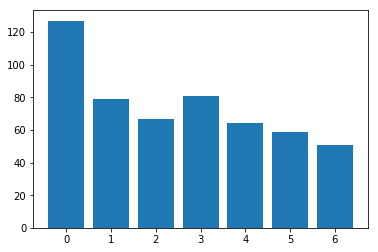

first_2


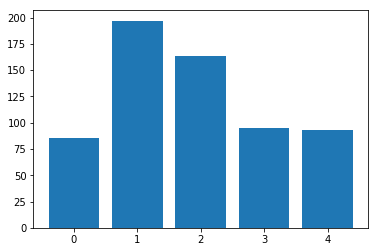

first_3


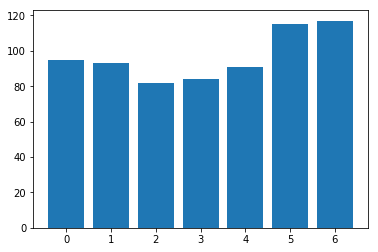

first_5


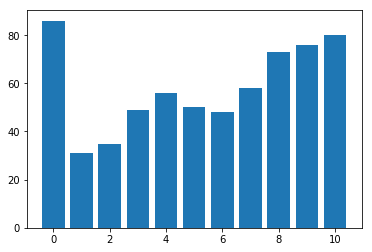

first_7


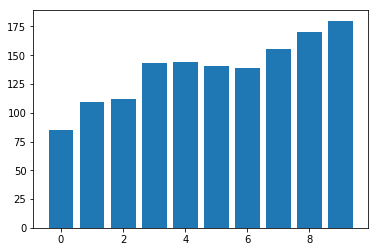

first_8


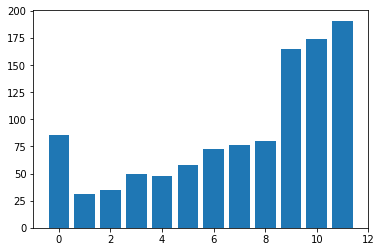

first_14


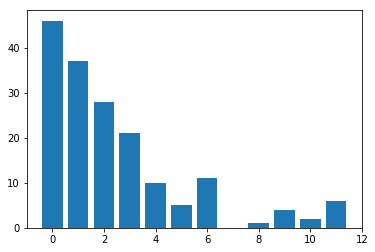

first_15


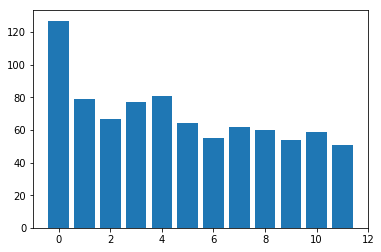

first_22


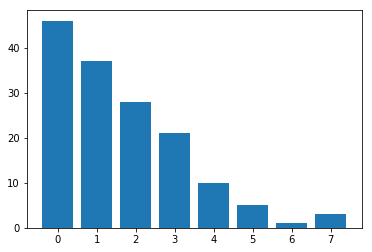

first_21


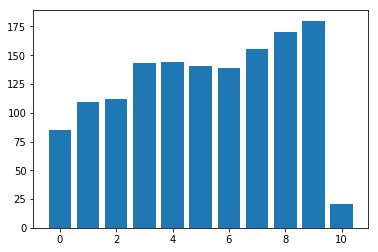

second_2


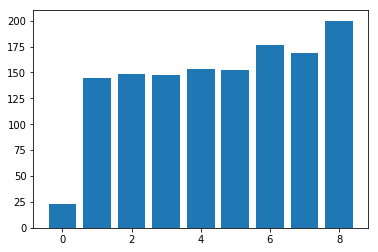

second_5


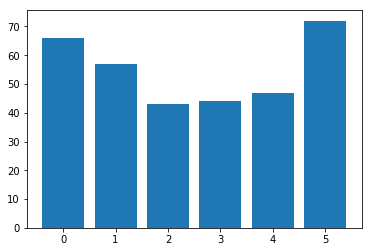

second_21


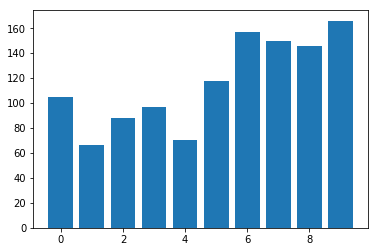

second_3


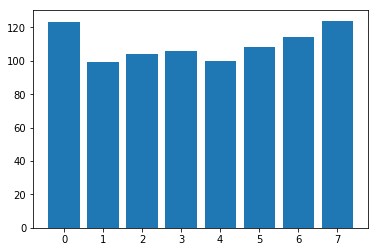

second_7


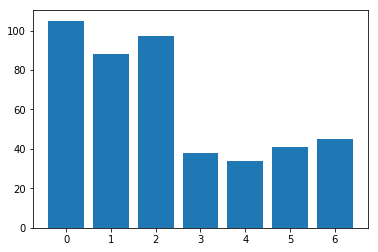

second_8


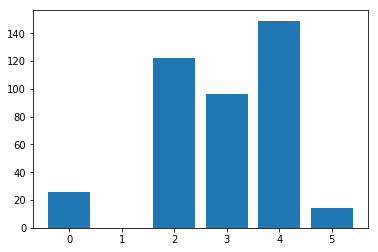

second_11


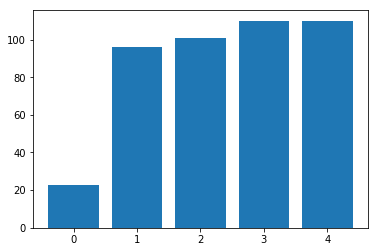

second_14


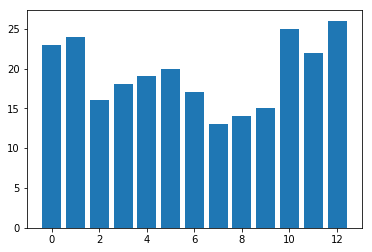

second_15


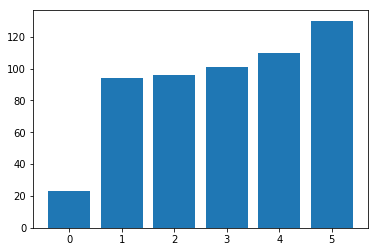

second_22


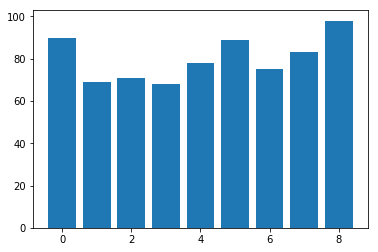

In [18]:
for key, arr in a.items():
    print(key)
    plt.bar(np.arange(len(arr)), arr)
    plt.show()

first_11


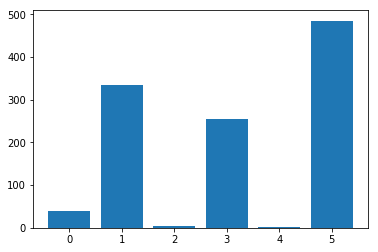

first_2


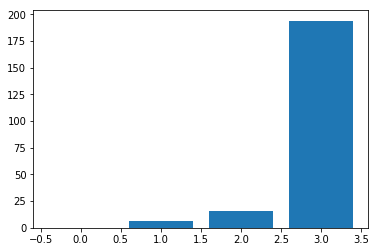

first_3


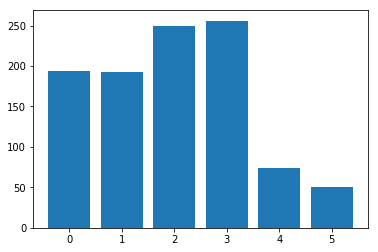

first_5


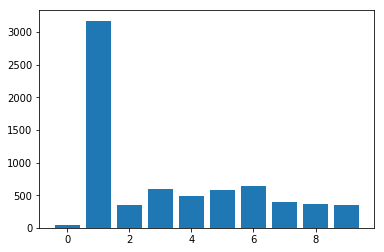

first_7


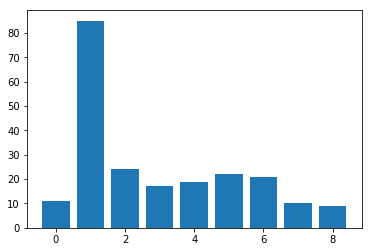

first_8


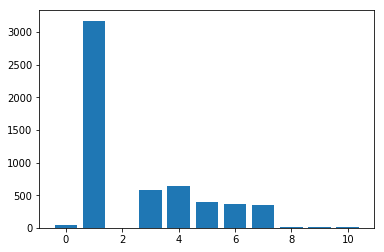

first_14


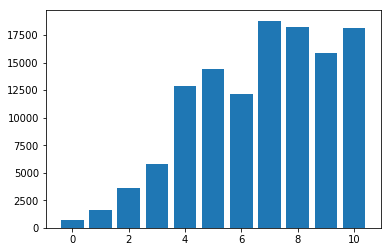

first_15


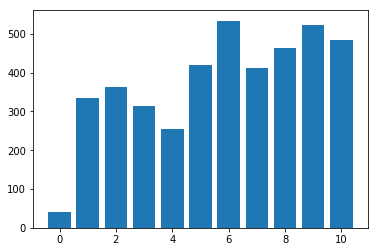

first_22


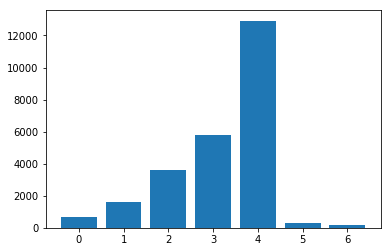

first_21


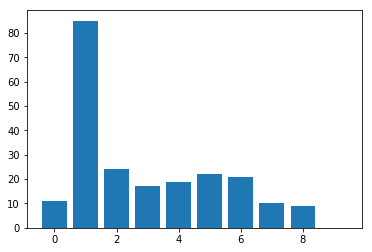

second_2


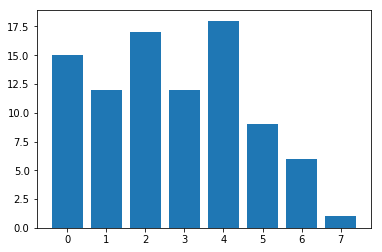

second_5


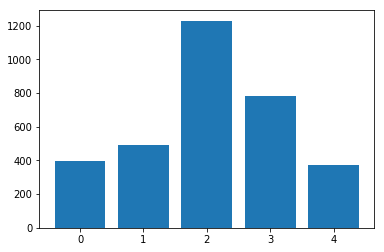

second_21


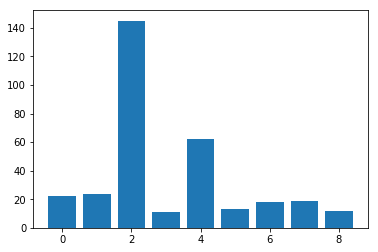

second_3


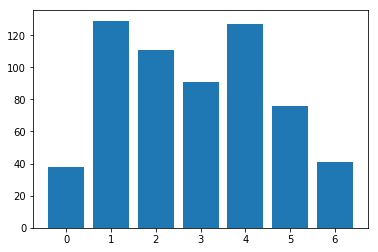

second_7


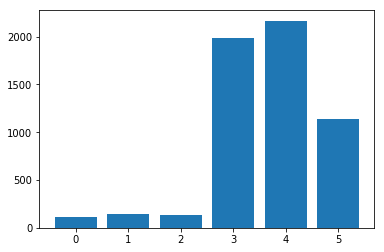

second_8


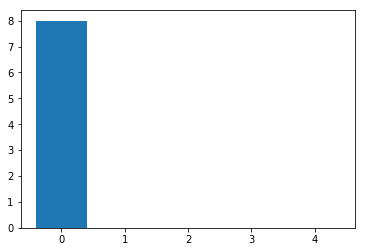

second_11


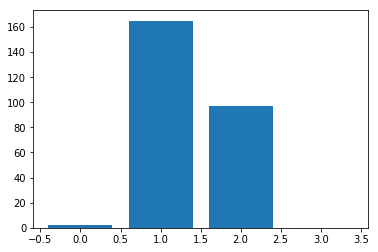

second_14


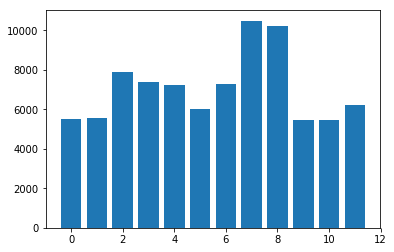

second_15


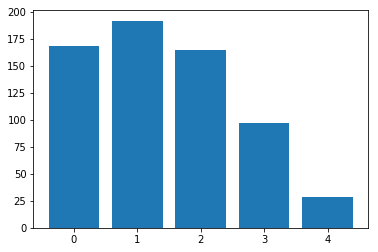

second_22


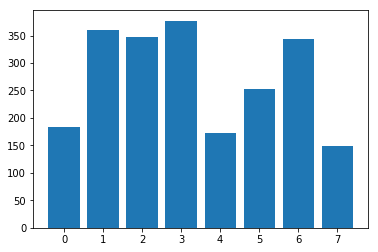

In [27]:
for key, arr in a.items():
    print(key)
    w = []
    for x,y in zip(arr, arr[1:]):
        w.append(gr[x, y])
        
    plt.bar(np.arange(len(w)), w)
    plt.show()

In [22]:
arr

[127, 79, 67, 81, 64, 59, 51]

In [25]:
strain 14 = 2 ng/ul
strain 7 = 1 ng/ul
strain 3 = 0.5 ng/ul
strain 5 = 0.25 ng/ul
strain 22 = 0.125 ng/ul
strain 15 = 0.0625 ng/ul
strain 21 = 0.031 ng/ul
strain 2 = 0.015 ng/ul
strain 8 = 0.007 ng/ul
strain 11 = 0.003 ng/ul

IndexError: tuple index out of range

In [30]:
for key, arr in a.items():
    print(key, np.median(arr))# np.median(sorted(arr)[1:-1]))
#     w = []
#     for x,y in zip(arr, arr[1:]):
#         w.append(gr[x, y])
        
#     plt.bar(np.arange(len(w)), w)
#     plt.show()

first_11 67.0
first_2 95.0
first_3 93.0
first_5 56.0
first_7 142.0
first_8 74.5
first_14 8.0
first_15 63.0
first_22 15.5
first_21 141.0
second_2 152.0
second_5 52.0
second_21 111.5
second_3 107.0
second_7 45.0
second_8 61.0
second_11 101.0
second_14 19.0
second_15 98.5
second_22 78.0


In [531]:
ca.rc('CCTTATAGGTACGGTTCAAAGGTTTCAAACCCTTATAGGTACGGTTCAAAGCCGGGGACTCCGCACTTGAGGTCATGGCAGACATCGGGTTTCAAACCCTCATAGGTACGGGTCAAAGCCTCCTTCTGGAAAGCGTTTGATTGCGGAGCATACCAGGTTTCAAACCCTTATAGGTACGGTTCAAAGGATGGAGGTGTCGCCATGGGGAACGAGGTAGTTCAGGTTTCAAGCCCTCATAGGTACGGTTCAAA', r = 1)

'TTTGAACCGTACCTATGAGGGCTTGAAACCTGAACTACCTCGTTCCCCATGGCGACACCTCCATCCTTTGAACCGTACCTATAAGGGTTTGAAACCTGGTATGCTCCGCAATCAAACGCTTTCCAGAAGGAGGCTTTGACCCGTACCTATGAGGGTTTGAAACCCGATGTCTGCCATGACCTCAAGTGCGGAGTCCCCGGCTTTGAACCGTACCTATAAGGGTTTGAAACCTTTGAACCGTACCTATAAGG'

In [271]:
from scipy.stats import shapiro

In [272]:
import pandas as pd

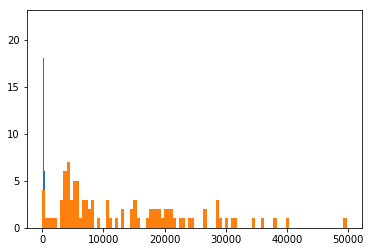

In [293]:
_ = plt.hist([x for x in pd.read_csv("../../../../../Downloads/630B_98spacers.csv")['x'].values], bins = 100)
_ = plt.hist([x for x in pd.read_csv("../../../../../Downloads/Run16_630_98spacers.csv")['x'].values], bins = 100)

Text(0.5,1,'630B')

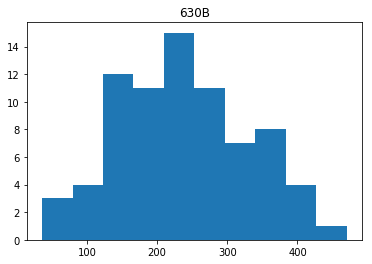

In [398]:
_ =plt.hist([x for x in pd.read_csv("../../../../../Downloads/630B_98spacers.csv")['x'].values if x > 25 and x < 1000], bins = 10)
plt.title('630B')
#_ =plt.hist([x for x in pd.read_csv("../../../../../Downloads/Run16_630_98spacers.csv")['x'].values if x > 25 ], bins = 100)

Text(0.5,1,'630А')

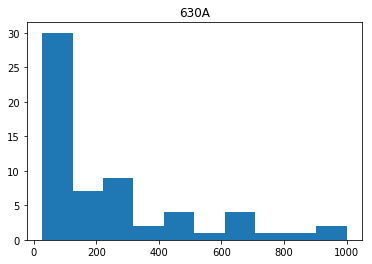

In [486]:
_ =plt.hist([x for x in pd.read_csv("../../../../../Downloads/630A_98spacers.csv")['x'].values if x > 25 and x < 1200], bins = 10)
plt.title('630А')

Text(0.5,1,'default')

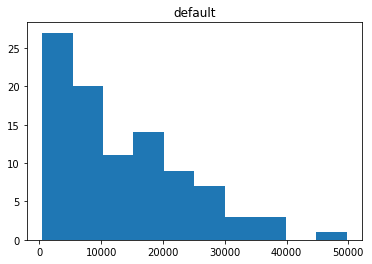

In [400]:

_ =plt.hist([x for x in pd.read_csv("../../../../../Downloads/Run16_630_98spacers.csv")['x'].values if x > 25], bins = 10)
plt.title('default')

In [281]:
shapiro([x for x in pd.read_csv("../../../../../Downloads/630B_98spacers.csv")['x'].values if x > 25 and x < 1000])

(0.984319269657135, 0.4725273549556732)

In [295]:
shapiro([x for x in pd.read_csv("../../../../../Downloads/Run16_630_98spacers.csv")['x'].values if x > 25 ])

(0.8944268226623535, 1.3315064961716416e-06)

In [479]:
a = np.array([x for x in pd.read_csv("../../../../../Downloads/630B_98spacers.csv")['x'].values if x > 25 and x < 1000])
b = np.array([x for x in pd.read_csv("../../../../../Downloads/Run16_630_98spacers.csv")['x'].values if x > 25 and x < 40000 ])
c_ = [x for x in pd.read_csv("../../../../../Downloads/630A_98spacers.csv")['x'].values if x  > 25 and x  < 1200]
             

In [480]:
c

[181, 166]

In [487]:
np.std(a / np.mean(a))

0.4030077933262295

In [488]:
np.std(b/ np.mean(b))

0.7447582476142027

In [489]:
np.std(c_ / np.mean(c_))

1.0375601630077886

In [484]:
c

[181, 166]

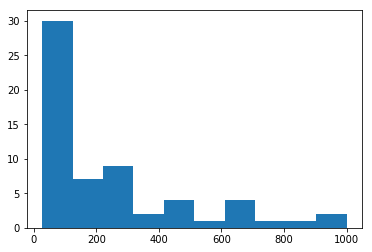

In [485]:
_ = plt.hist(c_)

In [478]:
pd.read_csv("../../../../../Downloads/630A_98spacers.csv")['x'].values [pd.read_csv("../../../../../Downloads/630A_98spacers.csv")['x'].values > 25 ]

array([ 158,   50,   68,  284,  435, 1666,  772,  531, 1236, 2260, 1228,
        242,   51,   58,   87,  251,  145,  201,  118,   44,   42,  342,
         88,   30,   39,  125,  162,   27,  106,  262,  216,  488,  276,
         80,   93,  434,  679,  628, 1356,  405,  673,   38,   79,   30,
        254,   57,   72,   54,   70, 4761, 1000,   30,   49,   84,   63,
         38,  227,  240,   83,  489,  300,  171,   56,   49,  944,  888,
        626, 1684])

(array([80., 10.,  4.,  2.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([   0. ,  476.1,  952.2, 1428.3, 1904.4, 2380.5, 2856.6, 3332.7,
        3808.8, 4284.9, 4761. ]),
 <a list of 10 Patch objects>)

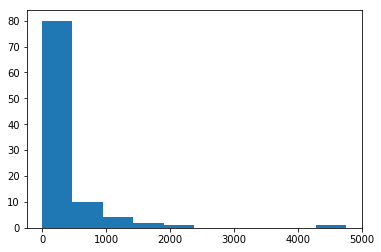

In [414]:
plt.hist(pd.read_csv("../../../../../Downloads/630A_98spacers.csv")['x'].values)

In [292]:
pd.read_csv("../../../../../Downloads/Run16_630_98spacers.csv")['x'].values

array([ 2035,  3140,  1845,  3098,  4462,  5302,  4679,  3763,  4299,
        7458,  5438,  3044,  1306,  4287,  8373, 15285, 29960, 19655,
       15540, 21258, 20021, 10842,  8239,  5830,     0,  3608,  5753,
        7778,  7957,  6252,  5915,  7402,  4178, 20810, 28486, 21547,
       26629, 31338, 17929, 18964, 21045, 22490, 26684, 34428, 29208,
       24247, 18149,  4105,   444,   737,  3519,  4449,  4798,  5397,
        5644,  6918,  9060,  7164,  7455,  5089,  6706, 30846, 17411,
       18502,  4619,  6552,  3912,  4349,  5210,  3773,  3877, 13072,
       37898, 14605, 19894, 17680, 14437, 17074, 20429, 13381, 18599,
       24634, 36158, 15014,  5751, 12401, 15043, 39818, 49710, 28712,
       10507, 10466, 23306, 28566, 19061, 11069,     0,     0])